In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from matplotlib.ticker import MaxNLocator
from scipy.stats import binom
from scipy.ndimage import uniform_filter
from sklearn.cluster import DBSCAN
from mapclassify import NaturalBreaks
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

In [3]:
nave_num = 35

In [4]:
data = pd.DataFrame()
for nave in [17,32,33,34,35]:
    for tiempo in list(range(1,13)):
        filename = f'./NAVE {nave}-{tiempo}.xlsx'
        if os.path.exists(filename):
            try:
                df = pd.read_excel(filename, header=[4]).drop('Unnamed: 0', axis=1)
                df = df.drop(df.index[-4:])
                df = df.melt(id_vars=['Unnamed: 1', 'Unnamed: 2'])
                df.columns = ['Tunel', 'Surco', 'Sitio_siembra', 'P-A']
                df['P-A'] = df['P-A'].fillna(0)
                df = df.ffill().infer_objects(copy=False)
                df['Sitio_siembra'] = pd.to_numeric(df['Sitio_siembra'], errors='coerce')
                df['Slap'] = (df['Sitio_siembra'] % 1 * 100).round().astype(int) + 1
                df['Sitio_siembra'] = df['Sitio_siembra'].astype(int)
                df['Nave'] = nave
                df['Tiempo'] = tiempo
                data = pd.concat([data, df], axis=0)
            except Exception:
                pass
        else:
            pass


In [5]:
def coef_var(x):
    return np.var(x) / np.mean(x) * 100

población = data.groupby(['Nave','Tiempo'])['P-A'].agg(['mean','std','var',coef_var]).reset_index()

In [6]:
Z = 1.96 
E = 0.05
m1 = []

for nave in data['Nave'].unique():
    for tiempo in data['Tiempo'].unique():
        df = data[(data['Nave']==nave)&(data['Tiempo']==tiempo)]
        N = len(df)
        p = np.mean(df['P-A'])
        n = (N * Z**2 * p * (1 - p)) / (E**2 * (N-1) + Z**2 * p * (1 - p))
        m1.append({'Nave': nave, 'Tiempo': tiempo, 'n': n,'Incidence':p*100})

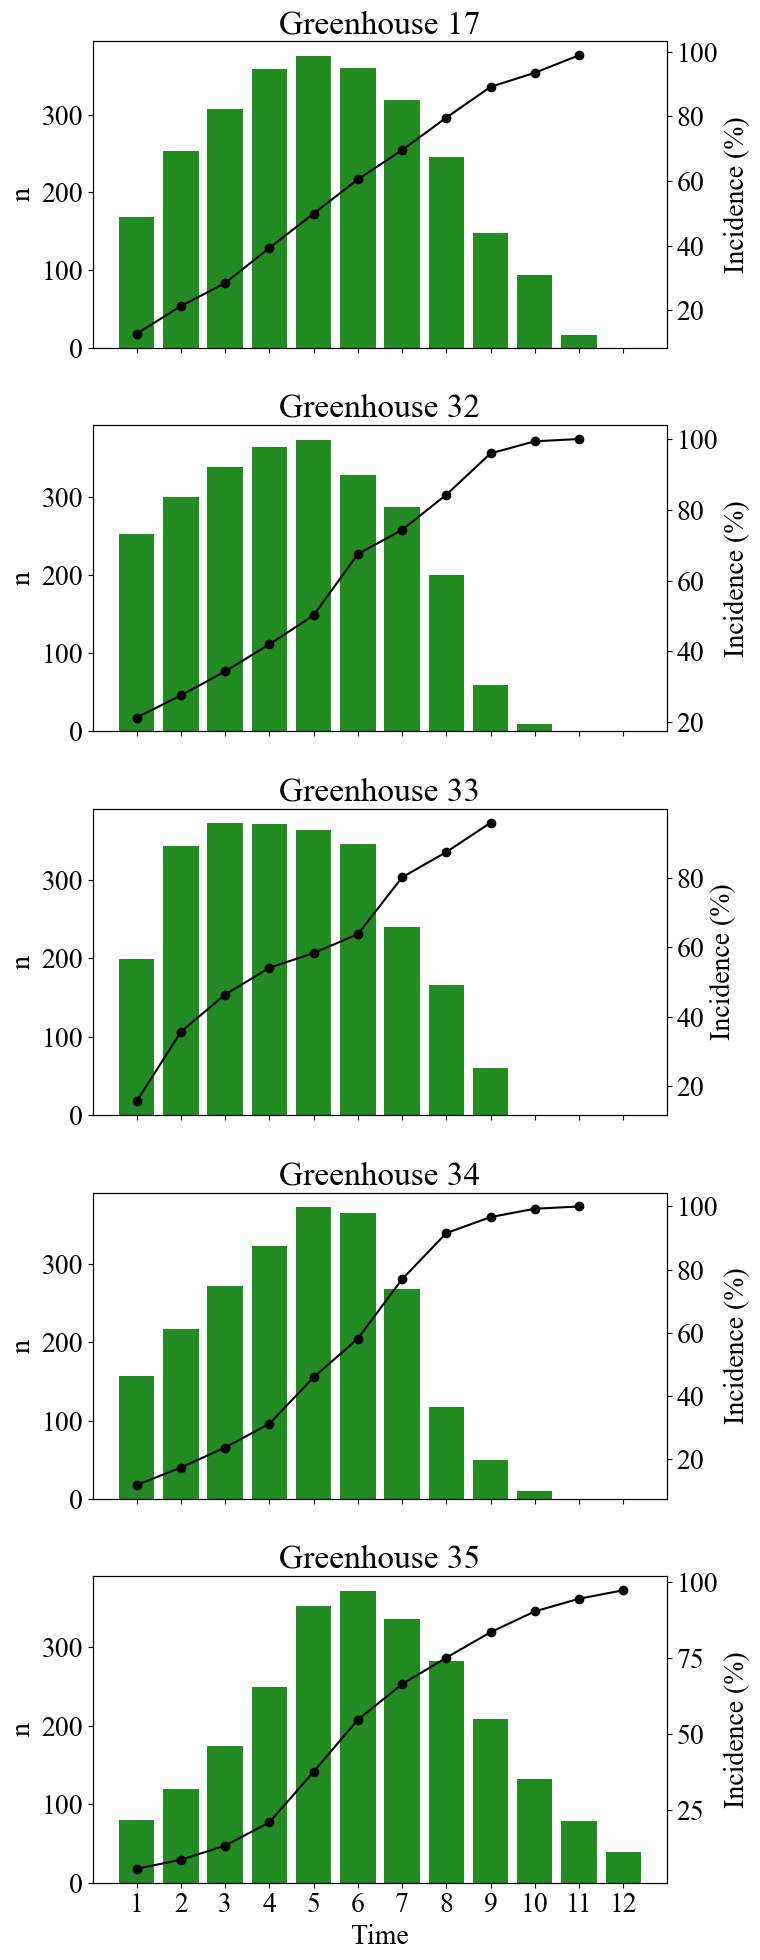

In [7]:
df_resultados = pd.DataFrame(m1)
naves = df_resultados['Nave'].unique()
tiempos = np.arange(1, 13)

fig, axes = plt.subplots(len(naves), 1, sharex=True, figsize=(8, 4*len(naves)))
for ax, nave in zip(axes, naves):
    df_plot = df_resultados[df_resultados['Nave'] == nave].sort_values('Tiempo')

    x = df_plot['Tiempo']
    y = df_plot['n']

    ax.bar(x, y, color='forestgreen', width=0.8)

    ax.set_title(f'Greenhouse {nave}')
    ax.set_ylabel('n')
    ax.set_xticks(tiempos)

    ax2 = ax.twinx()
    ax2.plot(df_plot['Tiempo'], df_plot['Incidence'], color='black', marker='o')
    ax2.set_ylabel('Incidence (%)', color='black')
    ax2.tick_params(axis='y', colors='black')

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

n_opt_for_prop = df_plot.copy()

In [8]:
data_35 = data[data['Nave'] == nave_num]
seed=2025

Tiempo 1, muestras optimo 15


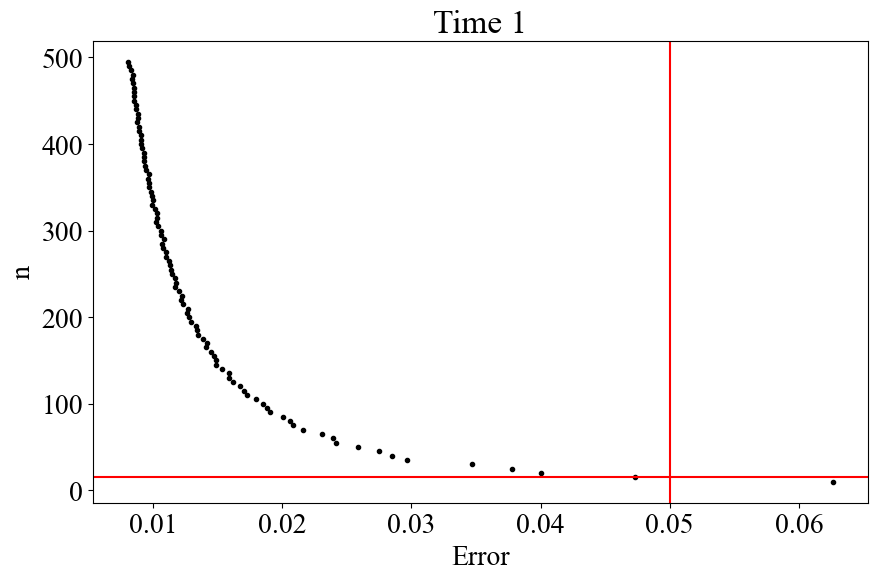

Tiempo 2, muestras optimo 25


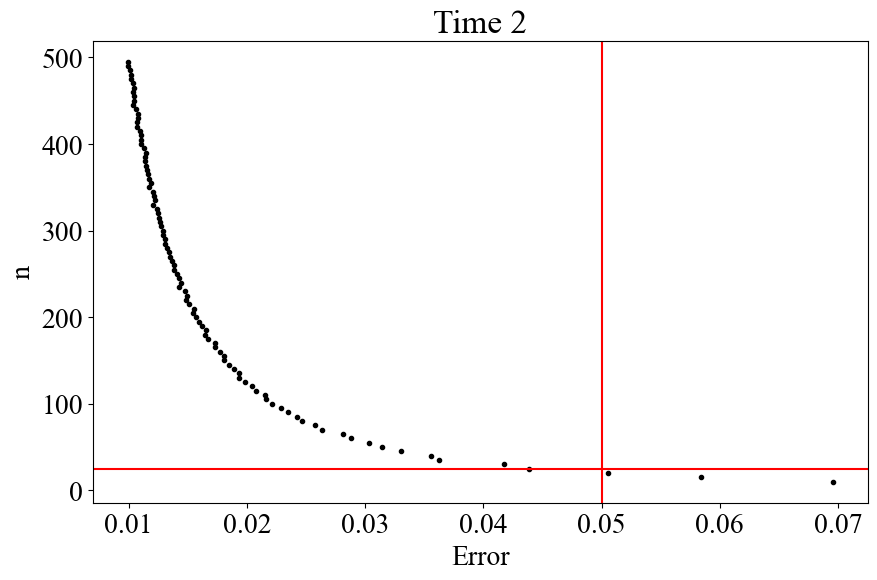

Tiempo 3, muestras optimo 30


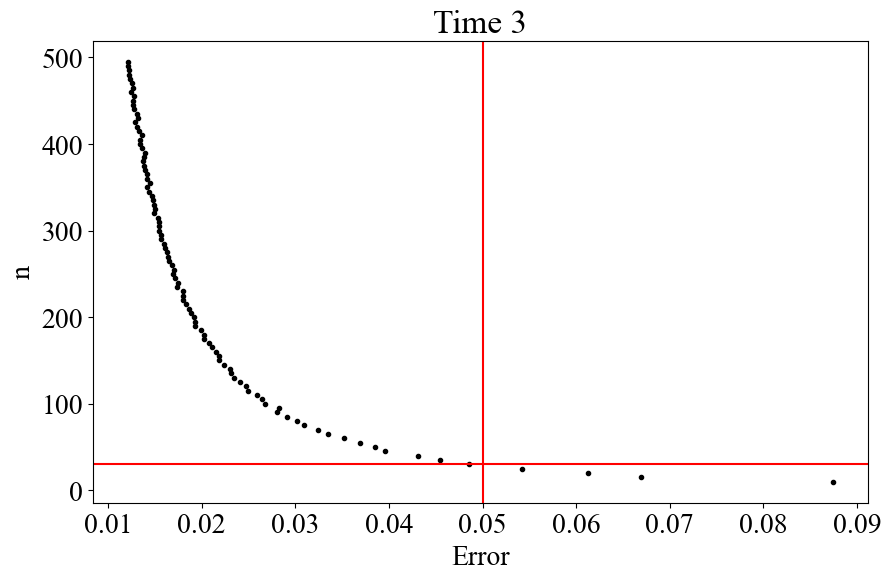

Tiempo 4, muestras optimo 45


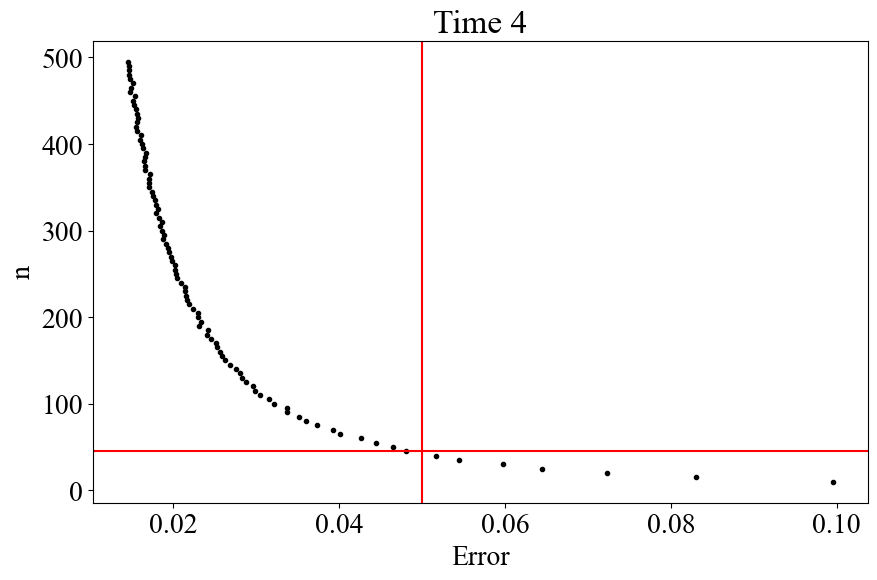

Tiempo 5, muestras optimo 65


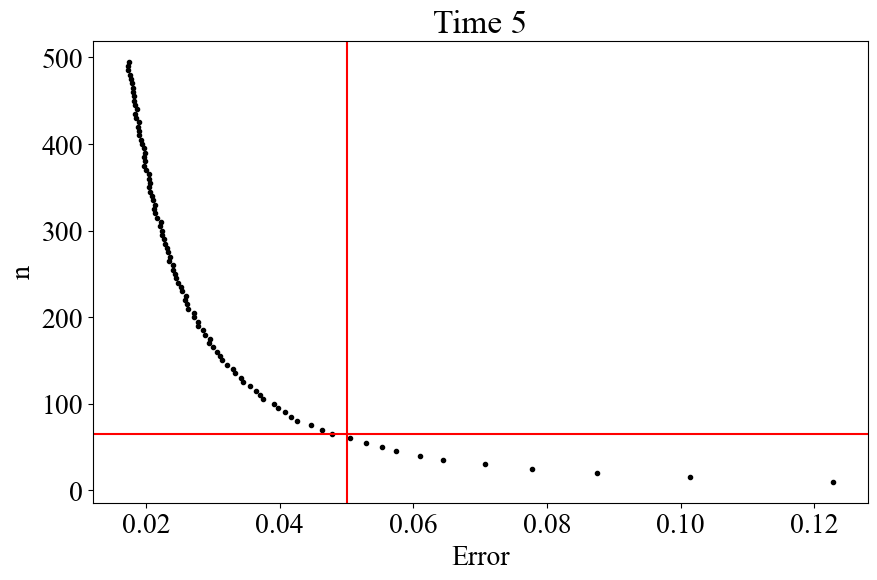

Tiempo 6, muestras optimo 65


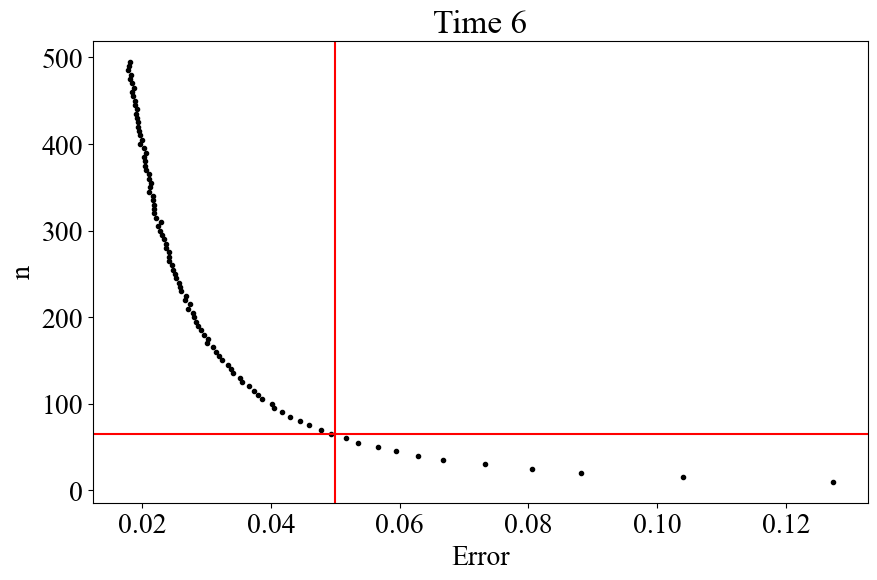

Tiempo 7, muestras optimo 60


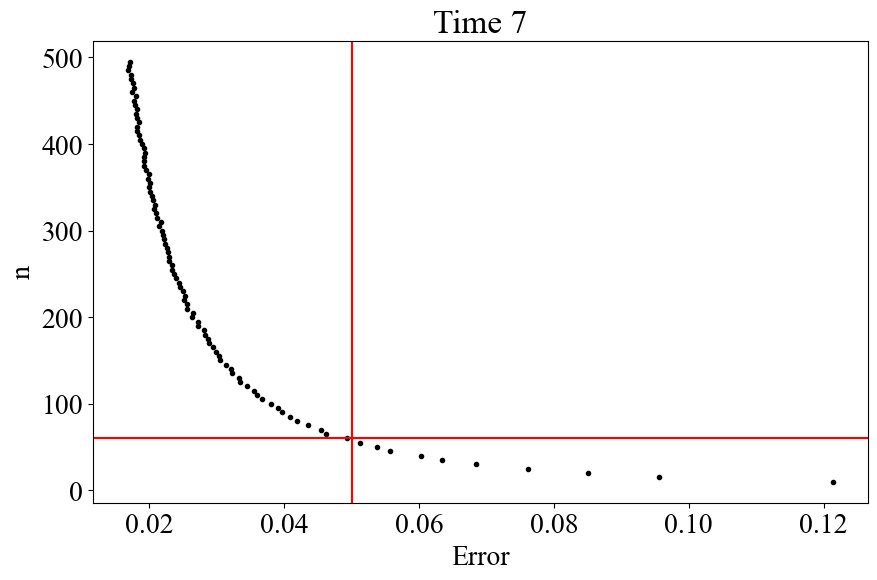

Tiempo 8, muestras optimo 50


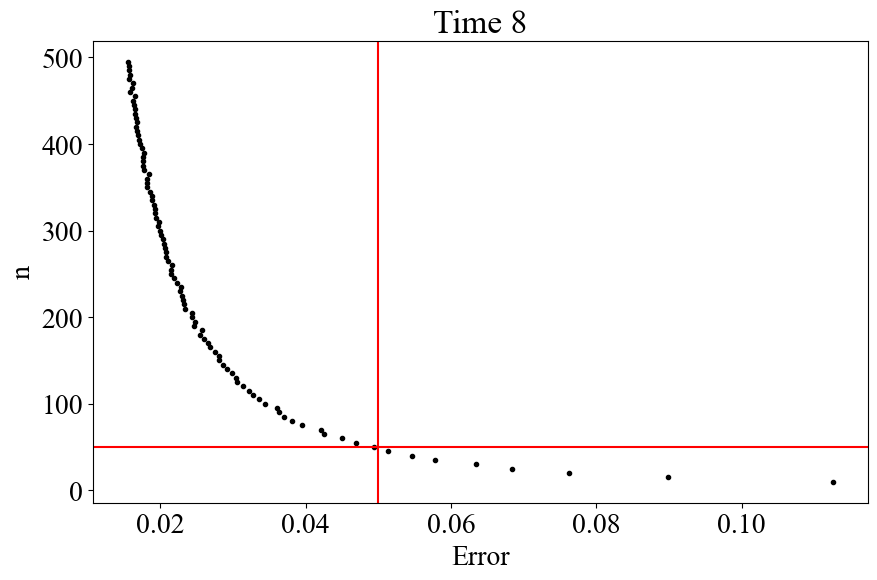

Tiempo 9, muestras optimo 35


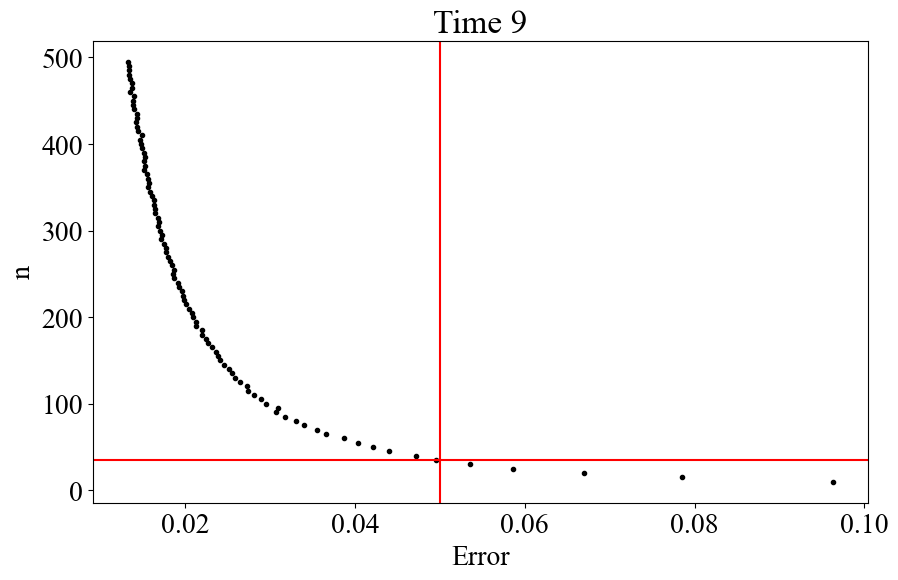

Tiempo 10, muestras optimo 25


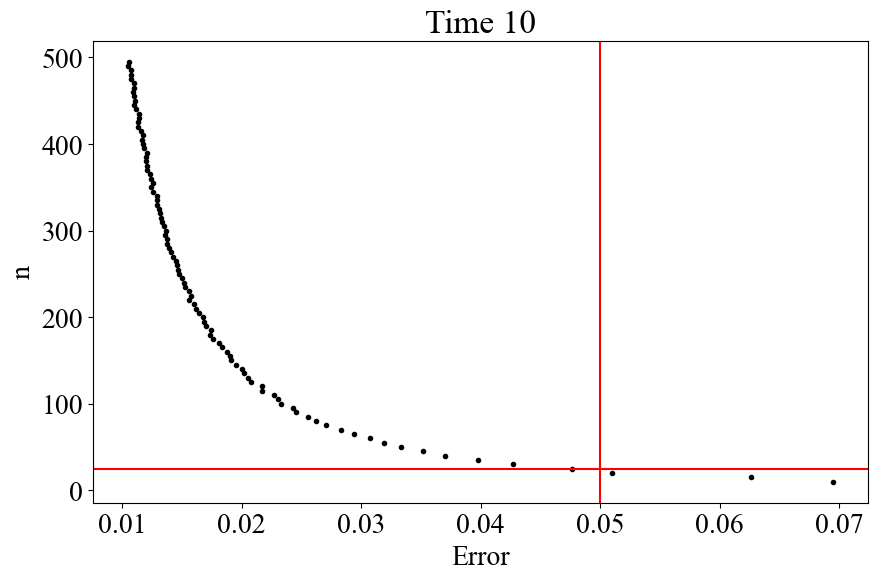

Tiempo 11, muestras optimo 15


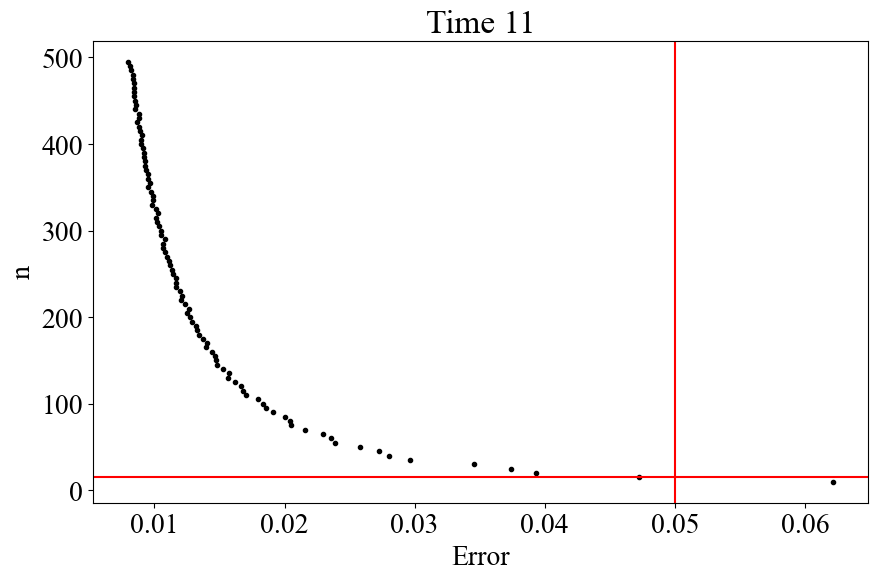

Tiempo 12, muestras optimo 10


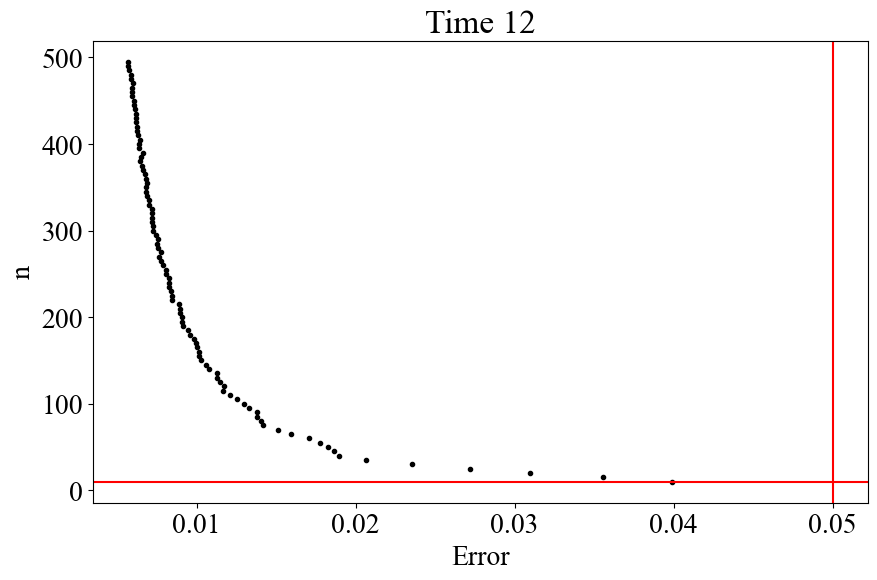

In [9]:
resultados = []
for tiempo in data_35['Tiempo'].unique():
    data_2_35 = data_35[data_35['Tiempo']==tiempo]
    p_hat = data_2_35['P-A'].mean()
    num_simulations = 10000
    error_objetivo = 0.05
    sample_sizes = np.arange(10, 500, 5)
    mean_errors = []

    np.random.seed(42)

    for n in sample_sizes:
        simulated_samples = np.random.binomial(1, p_hat, size=(num_simulations, n))
        sample_proportions = simulated_samples.mean(axis=1)
        errors = np.abs(sample_proportions - p_hat)
        mean_errors.append(errors.mean())

    mean_errors = np.array(mean_errors)

    idx_objetivo = np.where(mean_errors <= error_objetivo)[0][0]
    n_objetivo = sample_sizes[idx_objetivo]
    error_alcanzado = mean_errors[idx_objetivo]
    resultados.append({'Tiempo': tiempo, 'n_MC': n_objetivo})
    print(f'Tiempo {tiempo}, muestras optimo {n_objetivo}')
    plt.figure(figsize=(10, 6))
    plt.plot(mean_errors, sample_sizes, 'k.')  
    plt.axvline(x=error_objetivo, color='red', linestyle='-')  
    plt.axhline(y=n_objetivo, color='red', linestyle='-') 
    plt.title(f'Time {tiempo}')
    plt.xlabel('Error')
    plt.ylabel('n')
    plt.show()

n_opt_MC = pd.DataFrame(resultados)

In [10]:
def k_means(df, n, k_min=2, k_max=4):
    coords = df[['Sitio_siembra', 'Surco', 'P-A']].values
    
    inertias = []
    modelos = []
    for k in range(k_min, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init='auto').fit(coords)
        inertias.append(kmeans.inertia_)
        modelos.append(kmeans)
    
    diffs = np.diff(inertias)
    diffs_rel = diffs[1:] / diffs[:-1]  

    if len(diffs_rel) > 0:
        codo_idx = np.argmax(diffs_rel < 0.5) + 2 
        if codo_idx < k_min or codo_idx > k_max:
            k_opt = k_min
        else:
            k_opt = codo_idx
    else:
        k_opt = k_min
    
    print(f"Selected number of clusters by elbow method: {k_opt}")
    kmeans_opt = modelos[k_opt - k_min]
    df = df.copy()
    df['cluster'] = kmeans_opt.labels_
    
    clusters = df['cluster'].unique()
    samples_per_cluster = max(n // k_opt, 1)
    clusters_seleccionados = np.random.choice(clusters, size=k_opt, replace=False)
    samples = []
    for c in clusters_seleccionados:
        cluster_data = df[df['cluster'] == c]
        n_muestra = min(samples_per_cluster, len(cluster_data))
        samples.append(cluster_data.sample(n=n_muestra, random_state=seed))
    sample_cluster = pd.concat(samples)
    if len(sample_cluster) > n:
        sample_cluster = sample_cluster.sample(n=n, random_state=seed)
    return sample_cluster

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

def DBSCAN_method(df, n_muestra, eps=3, min_samples=5, random_state=42):
    """
    Muestreo basado en clusters usando DBSCAN.
    Los clusters se forman en función de la ubicación (Surco, Sitio_siembra)
    y la presencia/ausencia (P-A). Luego se asignan muestras proporcionales
    al tamaño del cluster.
    """

    X = df[['Sitio_siembra', 'Surco', 'P-A']].values

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    df = df.copy()
    df['cluster'] = db.labels_

    df = df[df['cluster'] != -1]

    if df.empty:
        raise ValueError("DBSCAN no encontró clusters válidos")

    cluster_sizes = df.groupby('cluster').size()
    n_cluster = np.round((cluster_sizes / cluster_sizes.sum()) * n_muestra).astype(int)

    diff = n_muestra - n_cluster.sum()
    if diff != 0:
        for i in cluster_sizes.sort_values(ascending=False).index[:abs(diff)]:
            n_cluster[i] += np.sign(diff)

    sample_list = []
    rng = np.random.default_rng(random_state)
    for cluster_id, n in n_cluster.items():
        subset = df[df['cluster'] == cluster_id]
        n = min(len(subset), n) 
        if n > 0:
            sample_list.append(subset.sample(n=n, random_state=random_state))

    sample = pd.concat(sample_list, ignore_index=True)

    return sample.drop_duplicates(subset=['Surco', 'Sitio_siembra'])


In [12]:
def Jenks_Natural_Breaks(df, n, n_clusters=4, grid_size=(10, 10)):
    df_copy = df.copy()
    df_copy['x_bin'] = pd.qcut(df_copy['Sitio_siembra'], q=grid_size[0], duplicates='drop')
    df_copy['y_bin'] = pd.qcut(df_copy['Surco'], q=grid_size[1], duplicates='drop')
    df_copy['cuadrante'] = df_copy['x_bin'].astype(str) + '_' + df_copy['y_bin'].astype(str)
    incidencia = df_copy.groupby('cuadrante')['P-A'].mean().reset_index()
    incidencia.columns = ['cuadrante', 'incidencia']
    try:
        jenks = NaturalBreaks(y=incidencia['incidencia'], k=n_clusters)
        incidencia['cluster'] = jenks.yb
    except Exception as e:
        print(f"Error en Jenks Natural Breaks: {e}")
        return pd.DataFrame()
    df_clusterizado = pd.merge(df_copy, incidencia[['cuadrante', 'cluster']], on='cuadrante')
    muestras = []
    for c in sorted(df_clusterizado['cluster'].unique()):
        grupo = df_clusterizado[df_clusterizado['cluster'] == c]
        n_muestra = min(len(grupo), int((len(grupo) / len(df_clusterizado)) * n))
        if n_muestra > 0:
            muestras.append(grupo.sample(n=n_muestra, random_state=seed))

    muestra_final = pd.concat(muestras).reset_index(drop=True)
    return muestra_final

In [13]:
custom_cmap = LinearSegmentedColormap.from_list("custom", ['lightgreen', 'red'])

In [14]:
n_opt = pd.merge(n_opt_for_prop,n_opt_MC, on='Tiempo')
n_opt

,Nave,Tiempo,n,Incidence,n_MC
0,35,1,79.985572,5.538462,15
1,35,2,118.772116,8.512821,25
2,35,3,173.668447,13.160256,30
3,35,4,249.514310,20.846154,45
4,35,5,352.115595,37.519231,65
5,35,6,371.709452,54.705128,65
6,35,7,335.553645,66.384615,60
7,35,8,281.817517,75.147436,50
8,35,9,208.696299,83.519231,35
9,35,10,132.343387,90.391026,25


In [15]:
from scipy.spatial.distance import cdist
from matplotlib.path import Path
from sklearn.preprocessing import StandardScaler

In [16]:
def calcular_estadisticas(sample):
    x = sample['P-A']
    media = x.mean()
    std = x.std()
    var = x.var()
    cv = (var / media * 100) if media != 0 else np.nan
    n = len(sample)
    p = media
    prob_enferma = 1 - binom.pmf(0, n, p) if n > 0 else np.nan
    return media, std, var, cv, prob_enferma

def plot_heatmap(sample, tiempo, metodo, df_tiempo):
    full_grid = pd.DataFrame(
        [(f, s) for f in sorted(df_tiempo['Surco'].unique())
                for s in sorted(df_tiempo['Sitio_siembra'].unique())],
        columns=['Surco', 'Sitio_siembra']
    )

    merged = pd.merge(full_grid, sample[['Surco', 'Sitio_siembra', 'P-A']],
                      on=['Surco', 'Sitio_siembra'], how='left')

    merged = merged.drop_duplicates(subset=['Surco', 'Sitio_siembra'])

    Plot_sample = merged.pivot(index='Surco', columns='Sitio_siembra', values='P-A')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        Plot_sample,
        cmap=custom_cmap,
        cbar=False,
        mask=Plot_sample.isnull(),
        linewidths=0,
        linecolor=None,
        vmin=0,  
        vmax=1 
    )
    plt.gca().invert_yaxis()
    plt.title(f'Heatmap {metodo} - Time {tiempo}', fontsize=20)
    plt.xlabel('Sowing site', fontsize=16)
    plt.ylabel('Furrow', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

metodos = {
    'k_means': k_means,
    'DBSCAN_method': DBSCAN_method,
    'Jenks_Natural_Breaks': Jenks_Natural_Breaks
}


--- Tiempo: 1 | Tamaño muestra ajustado: 79 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.077, Std: 0.268, Var: 0.072, CV: 93.51%, Prob. planta enferma: 0.998


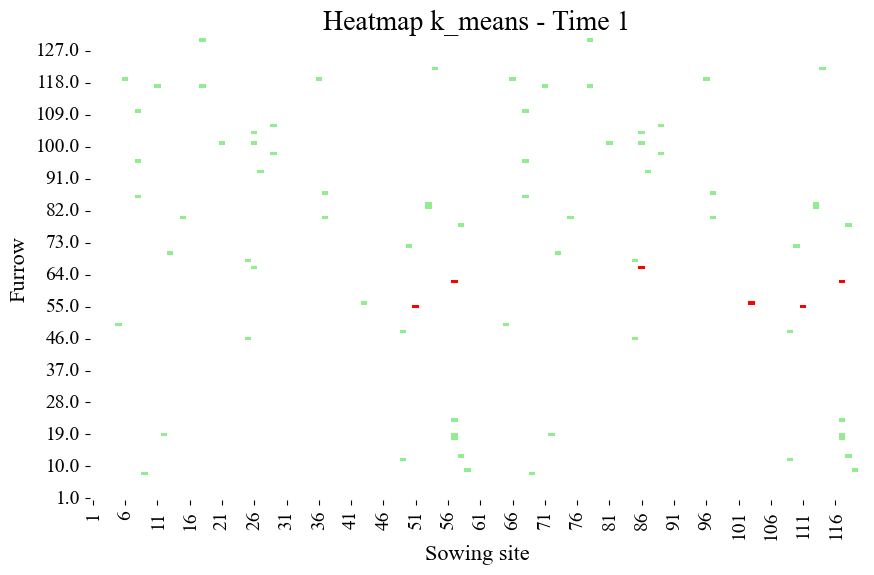

Método: DBSCAN_method
Media: 0.063, Std: 0.245, Var: 0.060, CV: 94.87%, Prob. planta enferma: 0.994


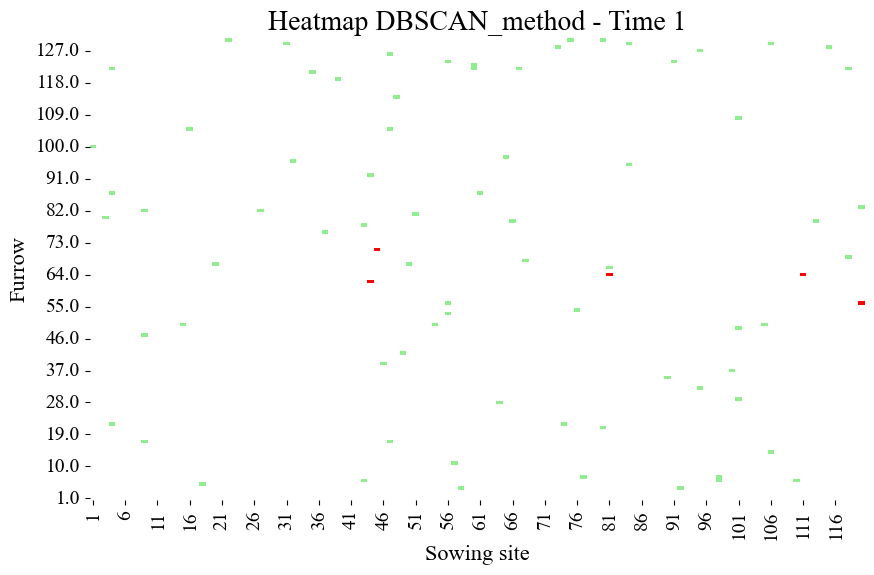

Método: Jenks_Natural_Breaks
Media: 0.079, Std: 0.271, Var: 0.074, CV: 93.33%, Prob. planta enferma: 0.998


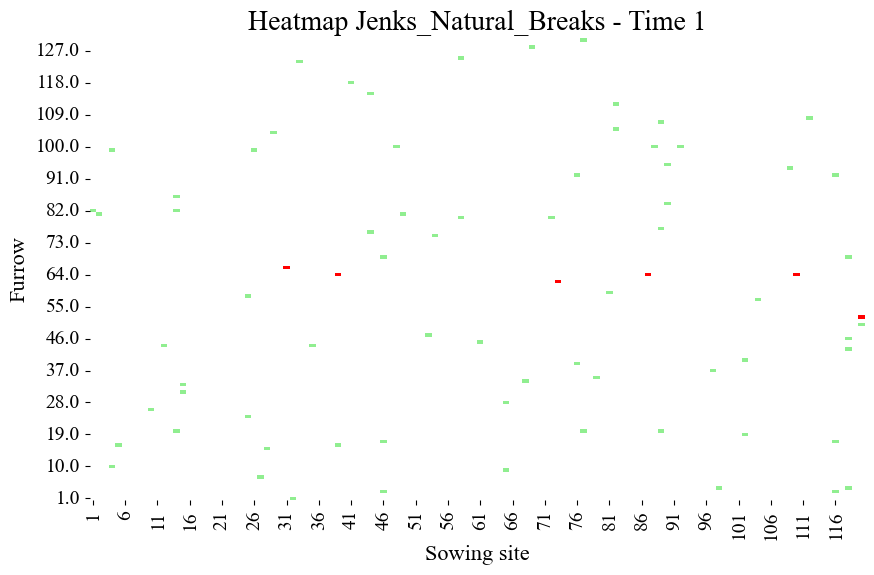


--- Tiempo: 2 | Tamaño muestra ajustado: 118 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.076, Std: 0.267, Var: 0.071, CV: 93.16%, Prob. planta enferma: 1.000


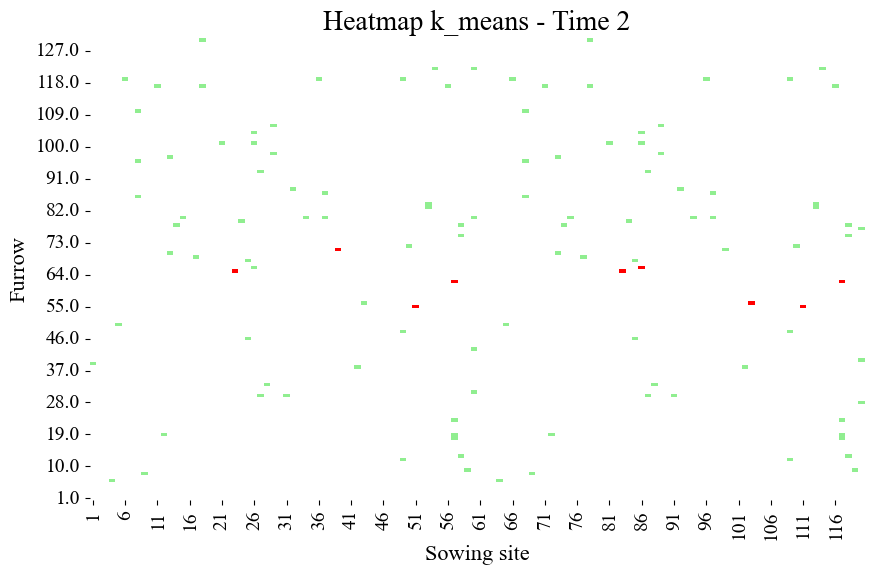

Método: DBSCAN_method
Media: 0.102, Std: 0.304, Var: 0.092, CV: 90.60%, Prob. planta enferma: 1.000


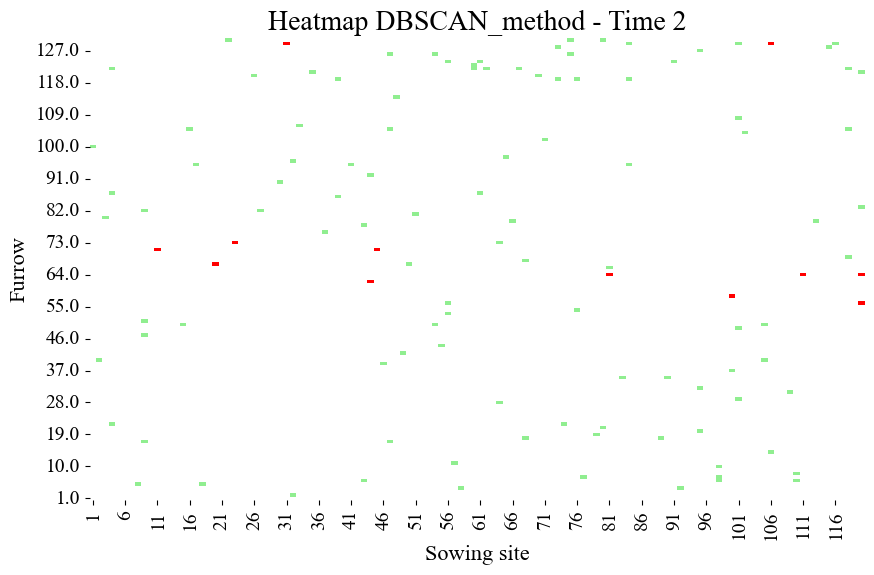

Método: Jenks_Natural_Breaks
Media: 0.060, Std: 0.239, Var: 0.057, CV: 94.78%, Prob. planta enferma: 0.999


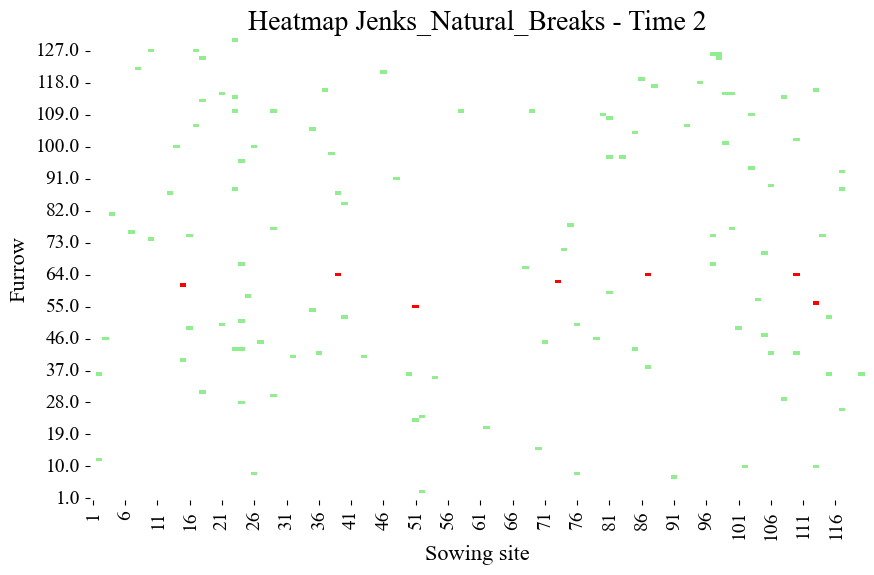


--- Tiempo: 3 | Tamaño muestra ajustado: 173 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.134, Std: 0.341, Var: 0.117, CV: 87.13%, Prob. planta enferma: 1.000


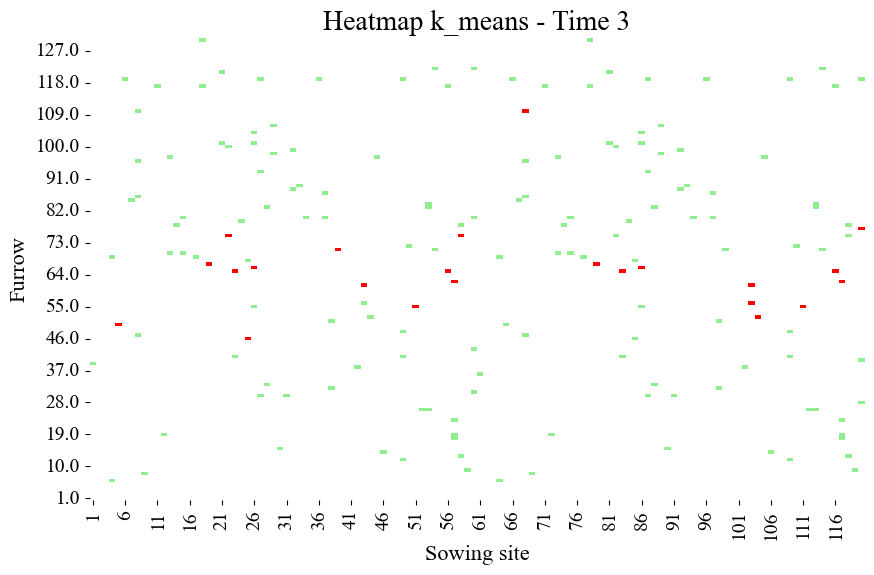

Método: DBSCAN_method
Media: 0.156, Std: 0.364, Var: 0.132, CV: 84.88%, Prob. planta enferma: 1.000


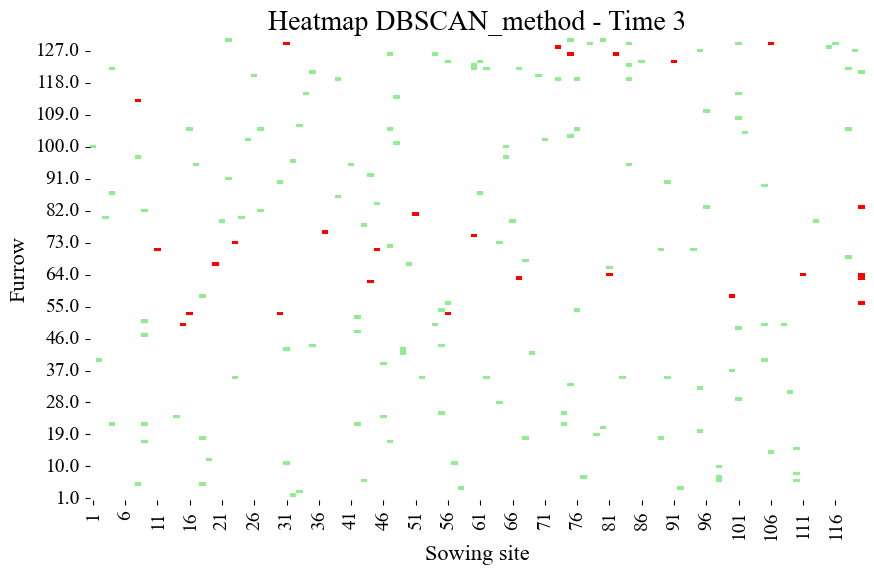

Método: Jenks_Natural_Breaks
Media: 0.140, Std: 0.348, Var: 0.121, CV: 86.47%, Prob. planta enferma: 1.000


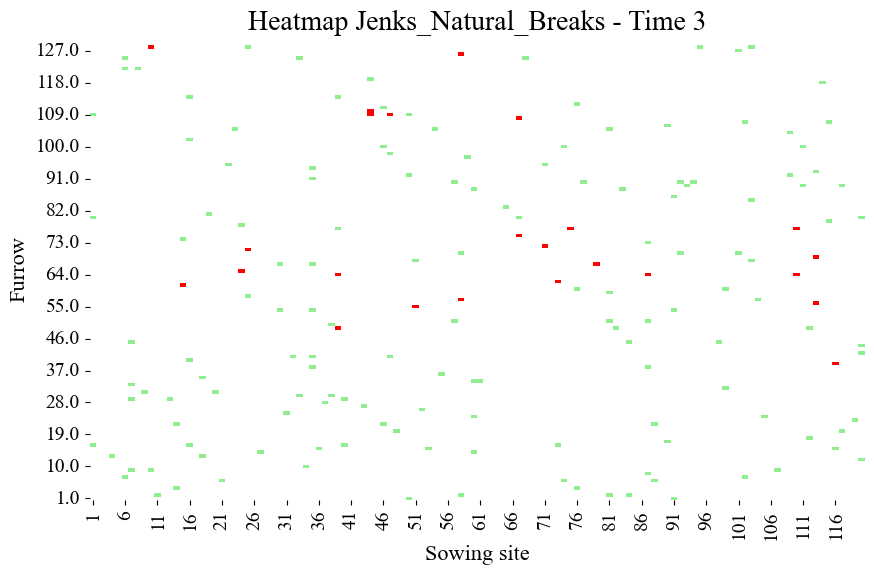


--- Tiempo: 4 | Tamaño muestra ajustado: 249 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.218, Std: 0.414, Var: 0.171, CV: 78.54%, Prob. planta enferma: 1.000


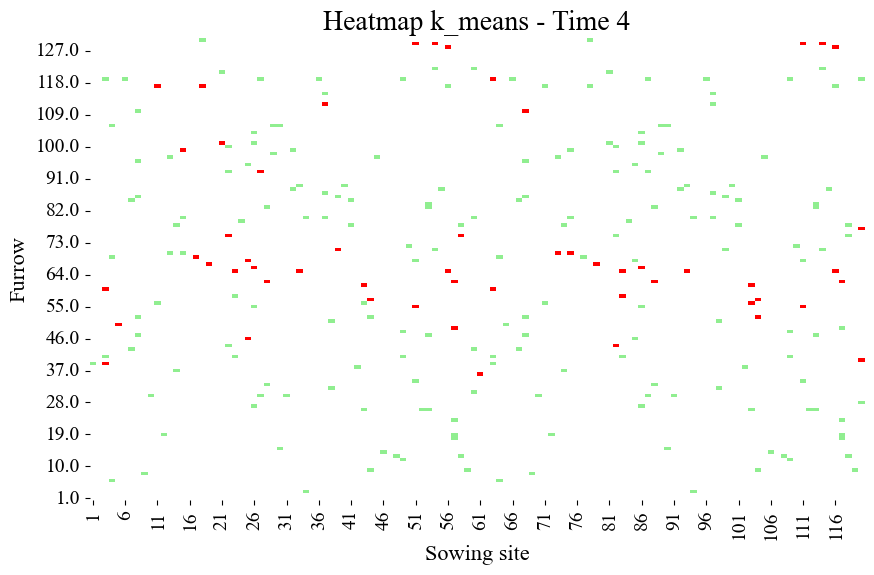

Método: DBSCAN_method
Media: 0.205, Std: 0.404, Var: 0.164, CV: 79.84%, Prob. planta enferma: 1.000


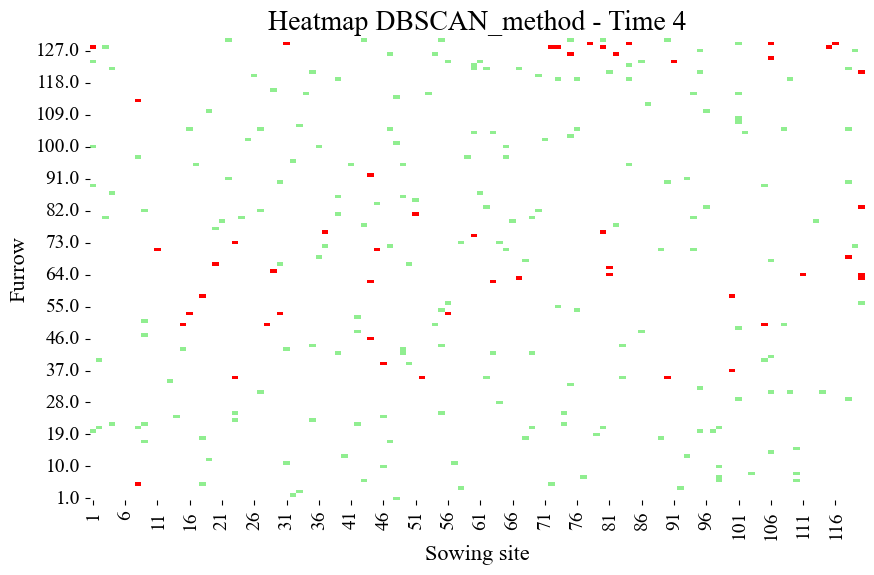

Método: Jenks_Natural_Breaks
Media: 0.211, Std: 0.409, Var: 0.167, CV: 79.27%, Prob. planta enferma: 1.000


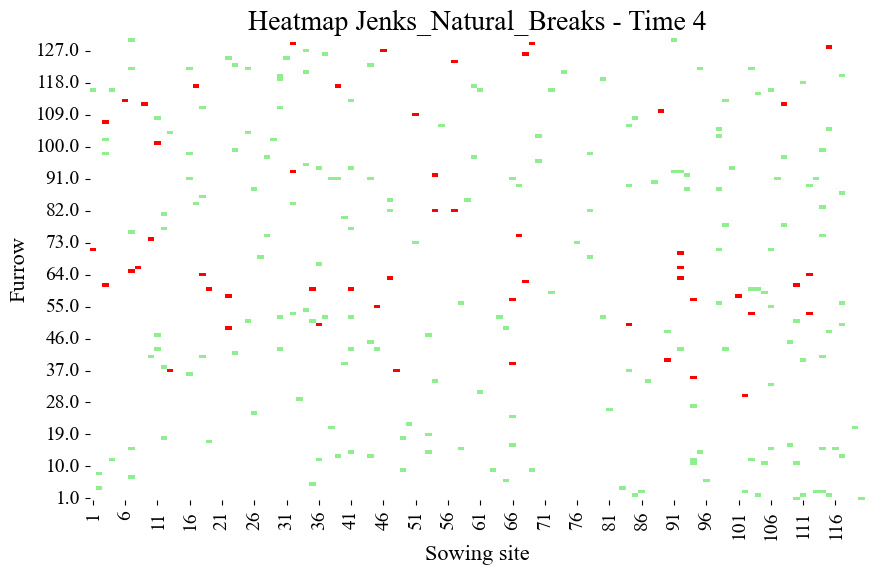


--- Tiempo: 5 | Tamaño muestra ajustado: 352 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.381, Std: 0.486, Var: 0.236, CV: 62.11%, Prob. planta enferma: 1.000


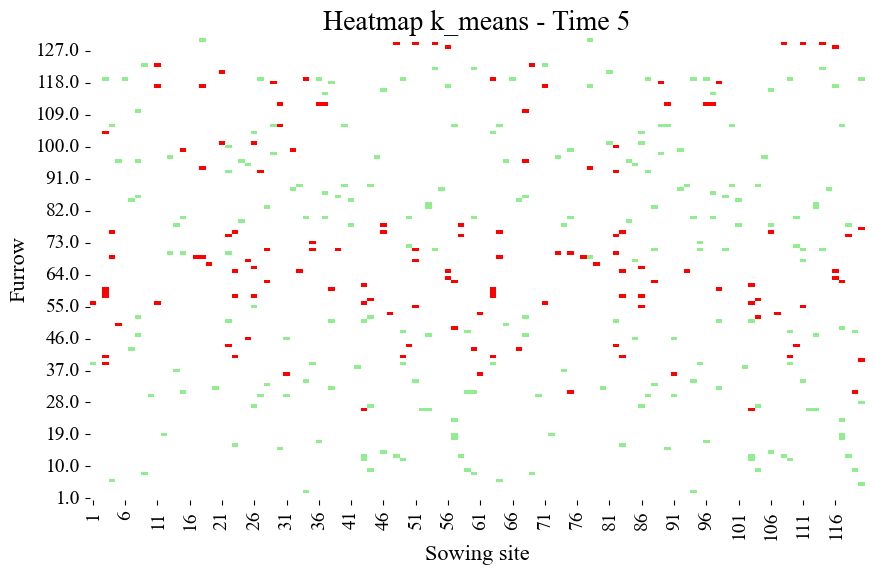

Método: DBSCAN_method
Media: 0.349, Std: 0.477, Var: 0.228, CV: 65.24%, Prob. planta enferma: 1.000


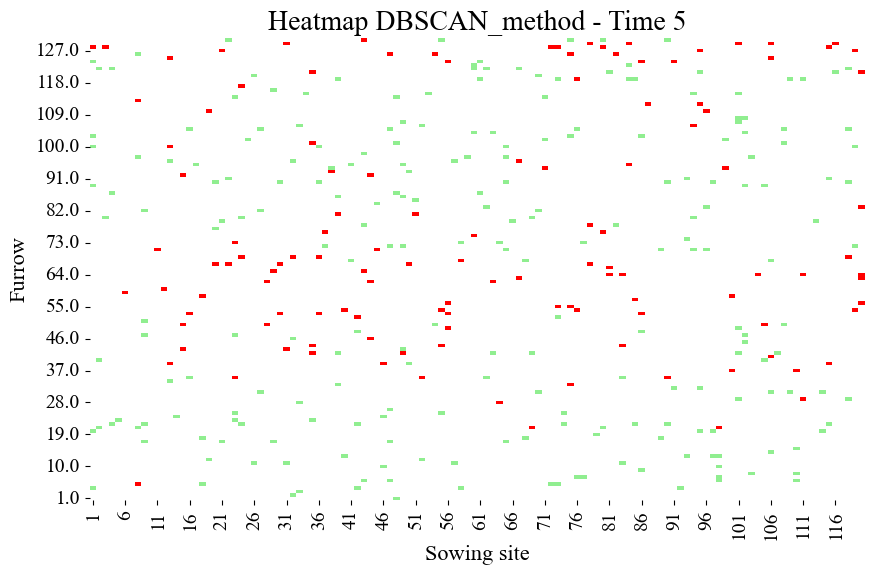

Método: Jenks_Natural_Breaks
Media: 0.402, Std: 0.491, Var: 0.241, CV: 60.00%, Prob. planta enferma: 1.000


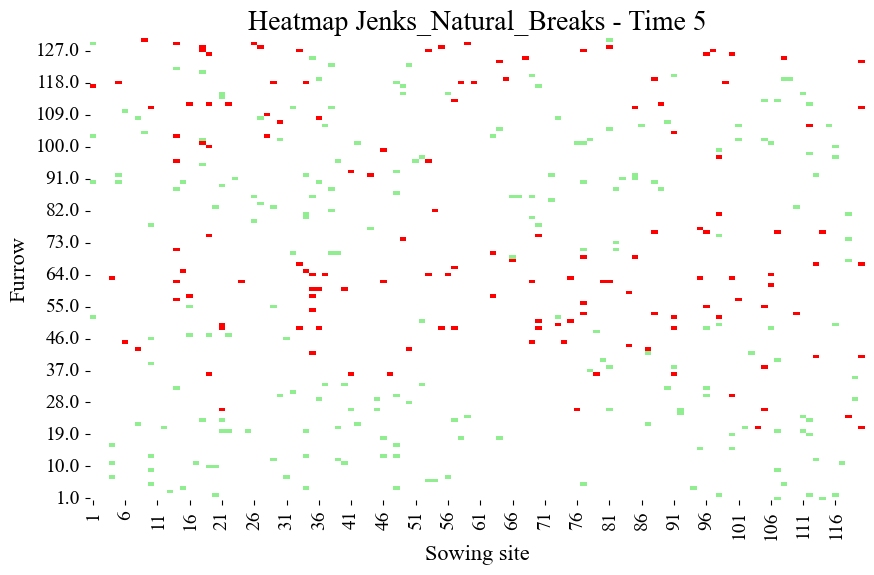


--- Tiempo: 6 | Tamaño muestra ajustado: 371 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.611, Std: 0.488, Var: 0.238, CV: 39.02%, Prob. planta enferma: 1.000


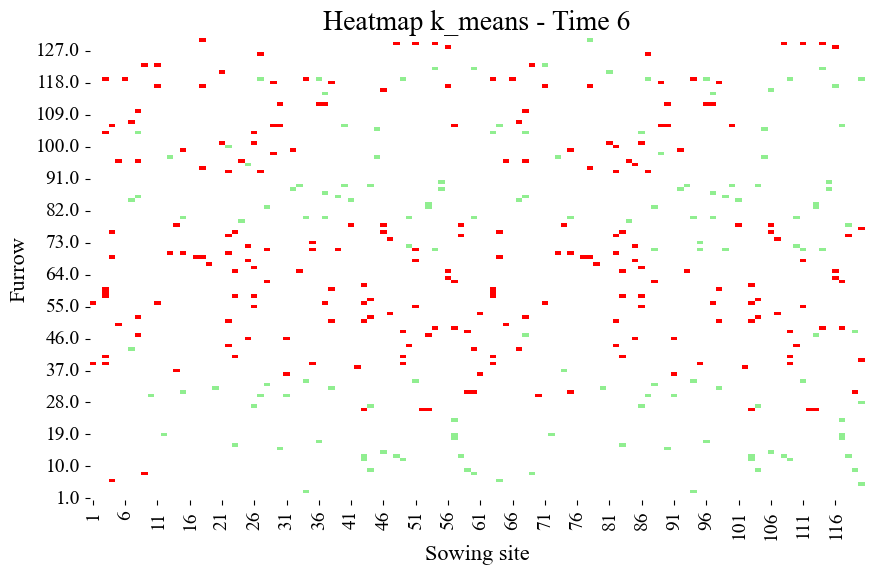

Método: DBSCAN_method
Media: 0.526, Std: 0.500, Var: 0.250, CV: 47.57%, Prob. planta enferma: 1.000


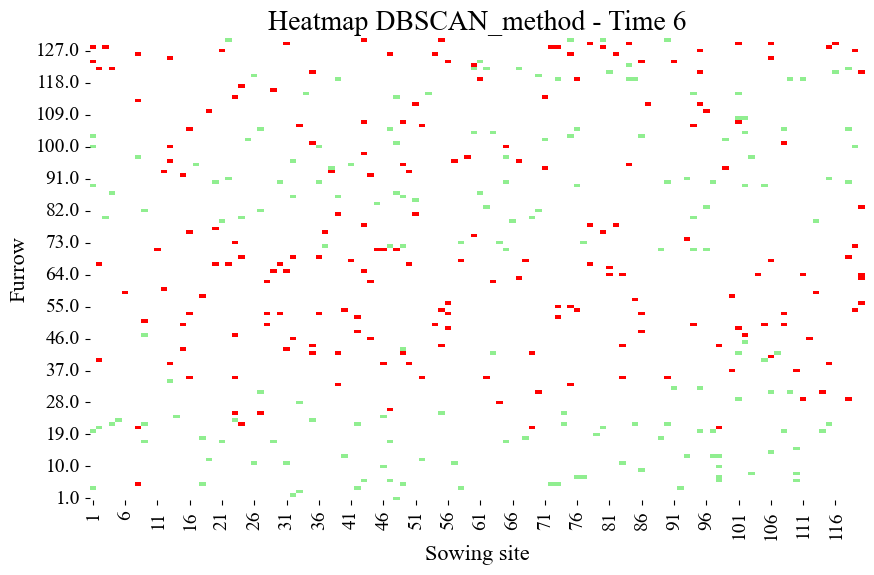

Método: Jenks_Natural_Breaks
Media: 0.484, Std: 0.500, Var: 0.250, CV: 51.76%, Prob. planta enferma: 1.000


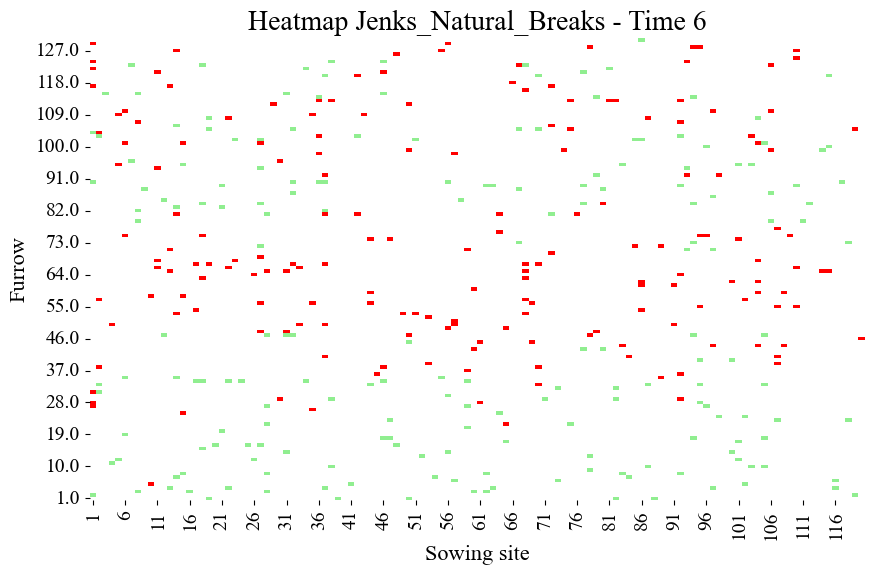


--- Tiempo: 7 | Tamaño muestra ajustado: 335 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.719, Std: 0.450, Var: 0.203, CV: 28.23%, Prob. planta enferma: 1.000


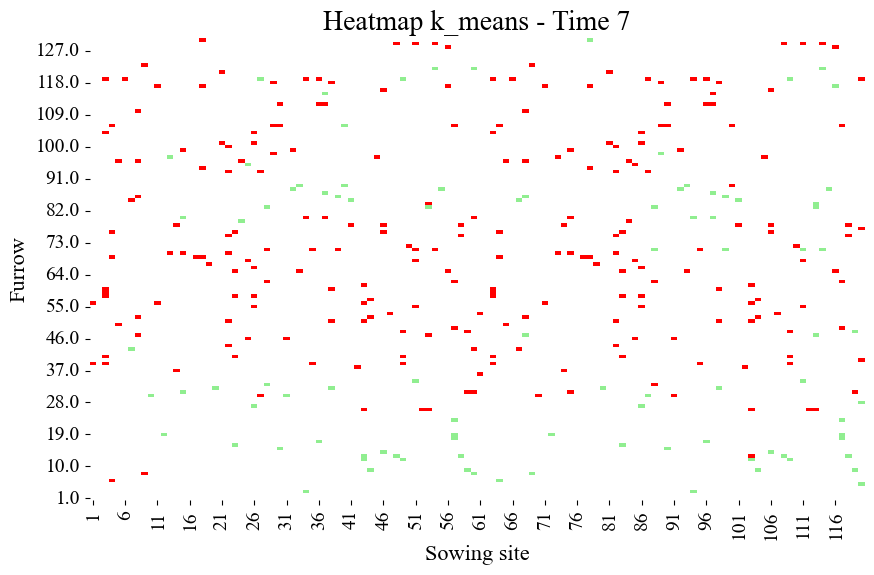

Método: DBSCAN_method
Media: 0.684, Std: 0.466, Var: 0.217, CV: 31.74%, Prob. planta enferma: 1.000


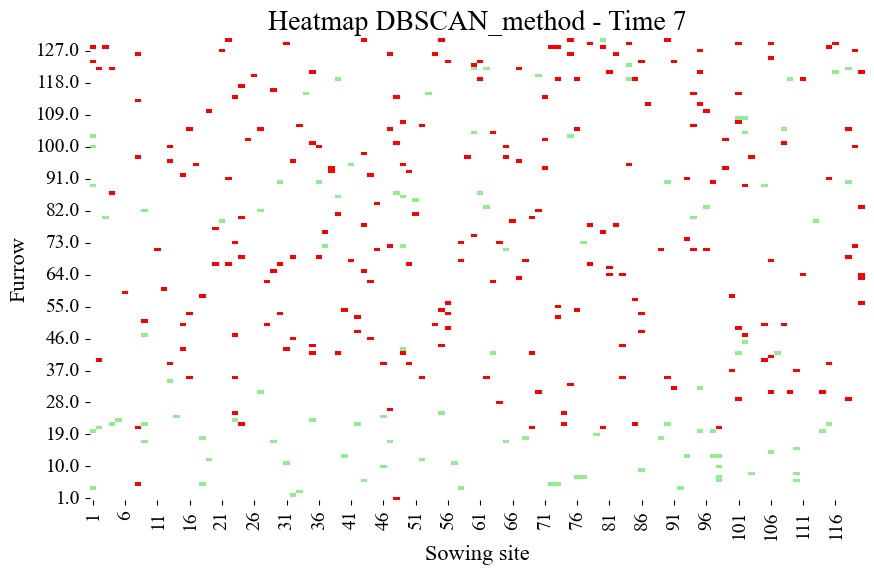

Método: Jenks_Natural_Breaks
Media: 0.688, Std: 0.464, Var: 0.215, CV: 31.33%, Prob. planta enferma: 1.000


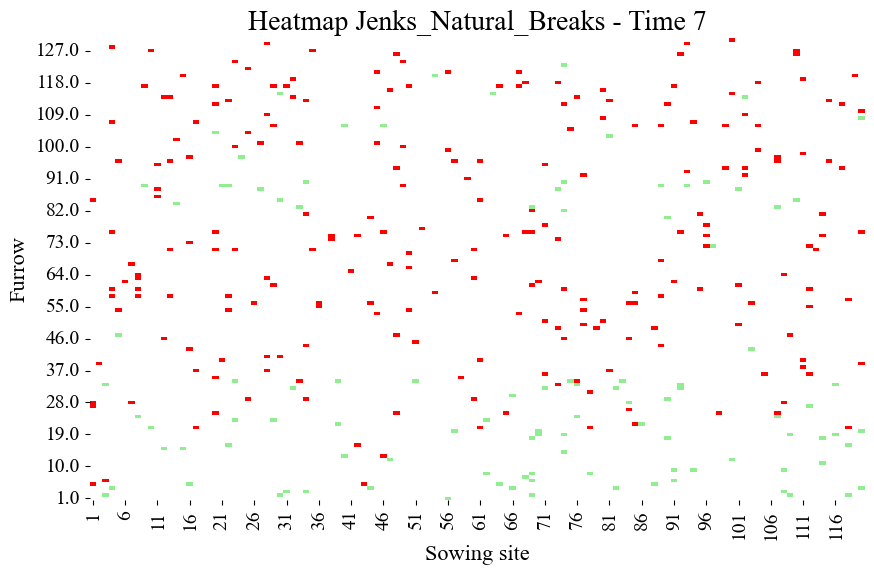


--- Tiempo: 8 | Tamaño muestra ajustado: 281 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.768, Std: 0.423, Var: 0.179, CV: 23.30%, Prob. planta enferma: 1.000


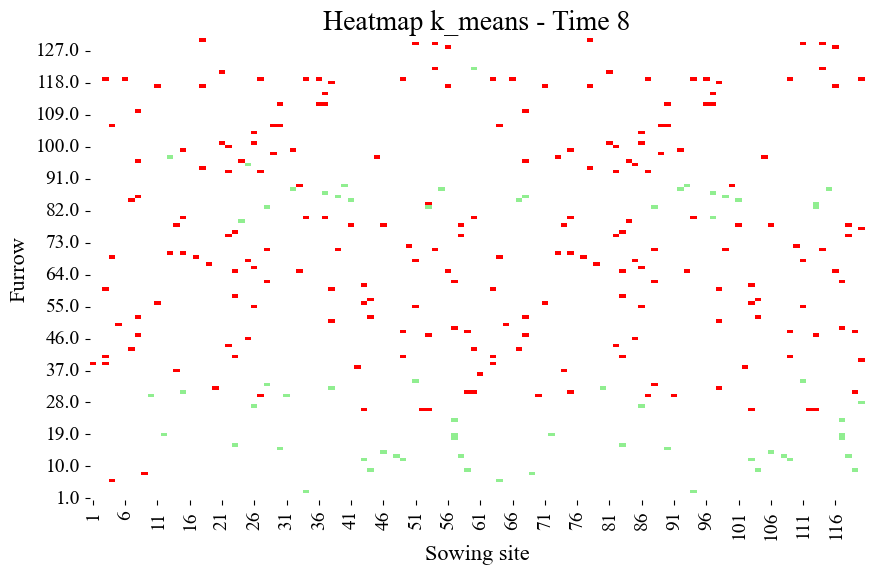

Método: DBSCAN_method
Media: 0.772, Std: 0.420, Var: 0.177, CV: 22.86%, Prob. planta enferma: 1.000


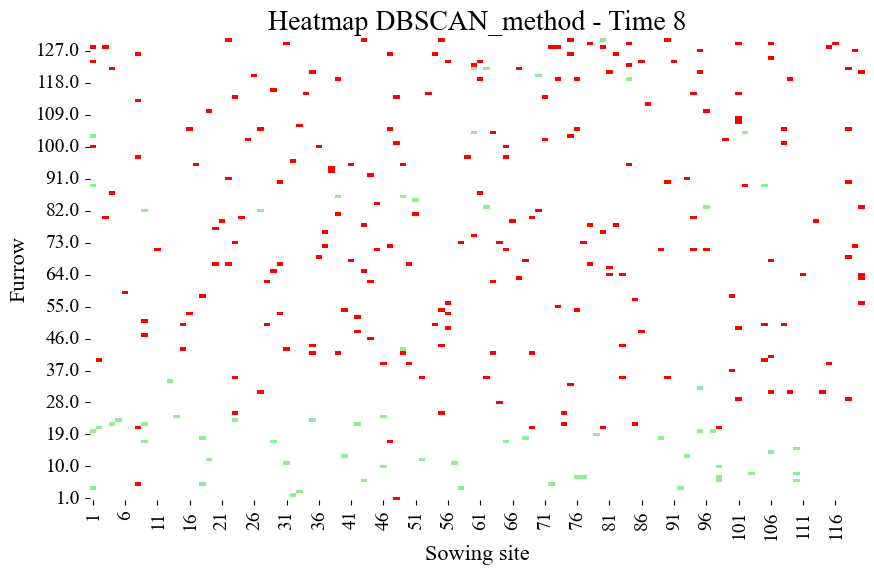

Método: Jenks_Natural_Breaks
Media: 0.728, Std: 0.446, Var: 0.199, CV: 27.34%, Prob. planta enferma: 1.000


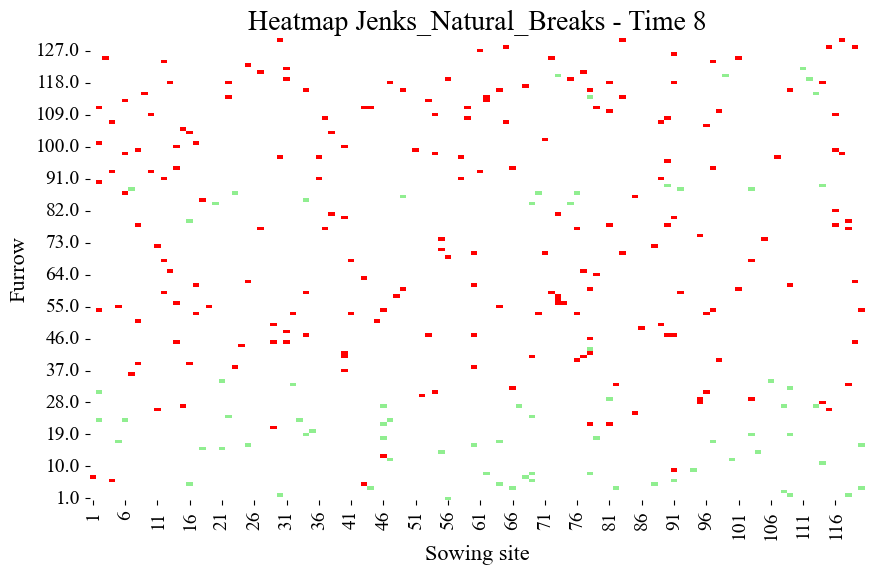


--- Tiempo: 9 | Tamaño muestra ajustado: 208 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.856, Std: 0.352, Var: 0.124, CV: 14.49%, Prob. planta enferma: 1.000


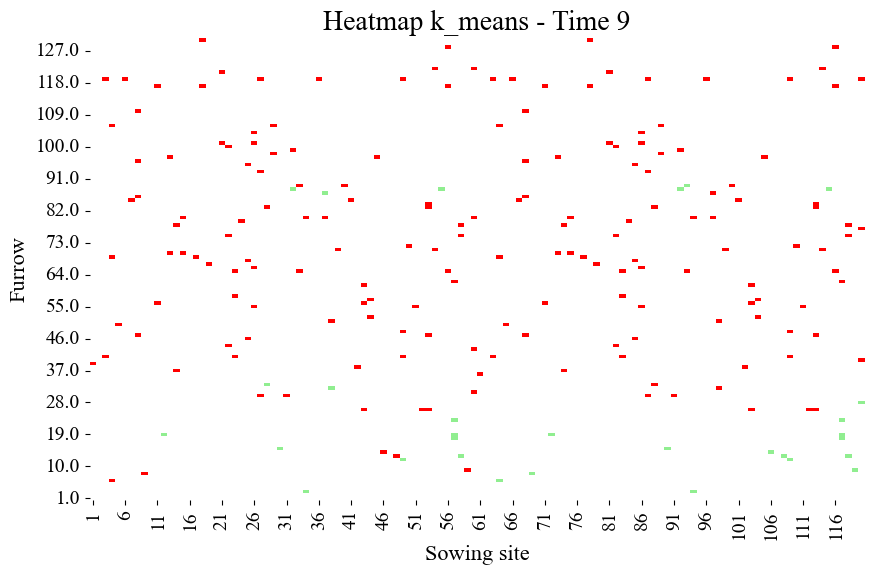

Método: DBSCAN_method
Media: 0.856, Std: 0.352, Var: 0.124, CV: 14.49%, Prob. planta enferma: 1.000


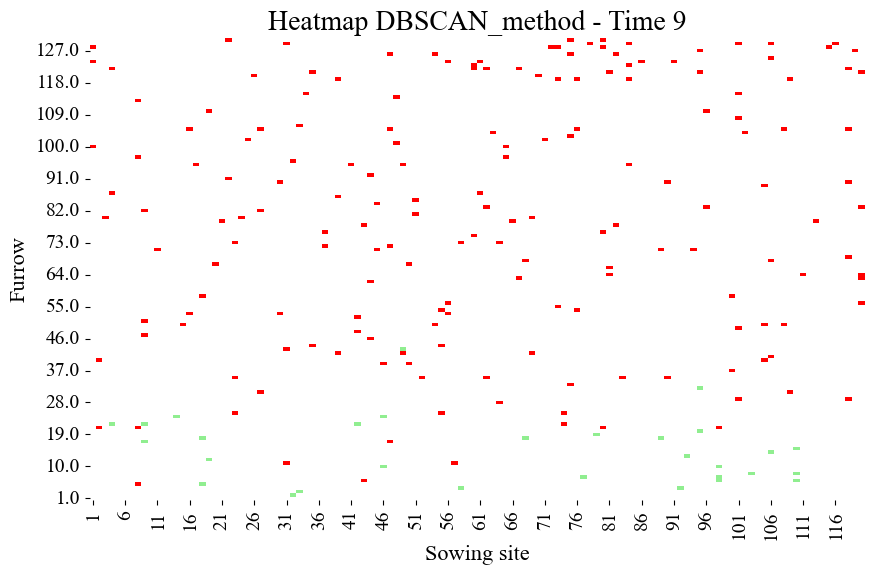

Método: Jenks_Natural_Breaks
Media: 0.850, Std: 0.358, Var: 0.128, CV: 15.05%, Prob. planta enferma: 1.000


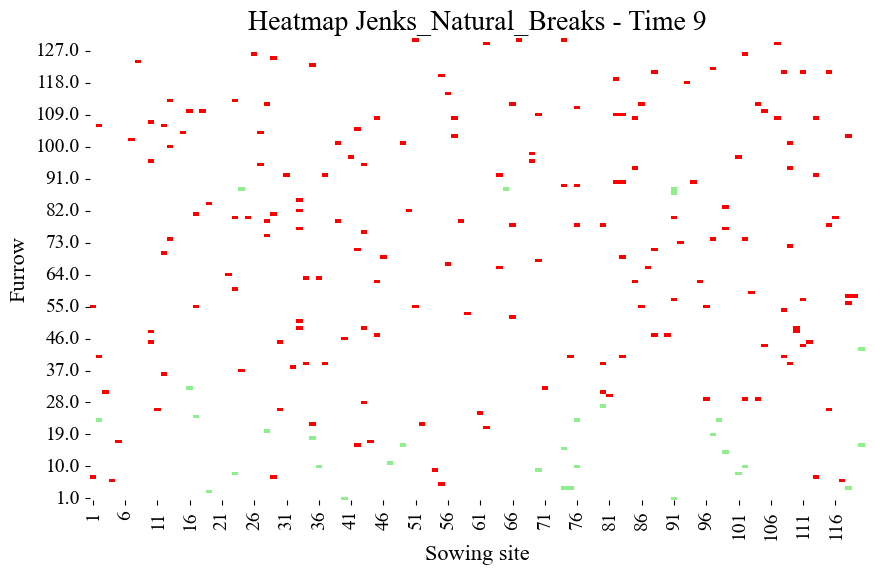


--- Tiempo: 10 | Tamaño muestra ajustado: 132 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.894, Std: 0.309, Var: 0.096, CV: 10.69%, Prob. planta enferma: 1.000


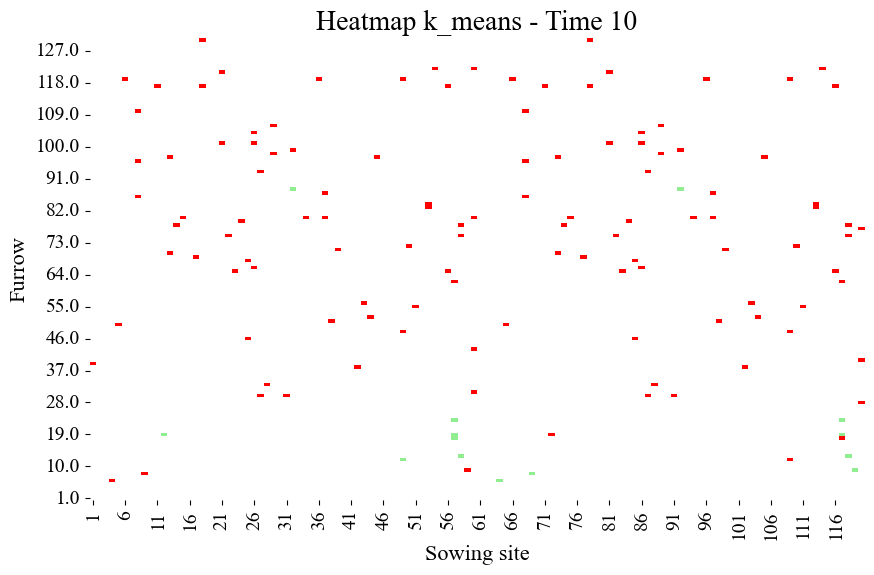

Método: DBSCAN_method
Media: 0.909, Std: 0.289, Var: 0.083, CV: 9.16%, Prob. planta enferma: 1.000


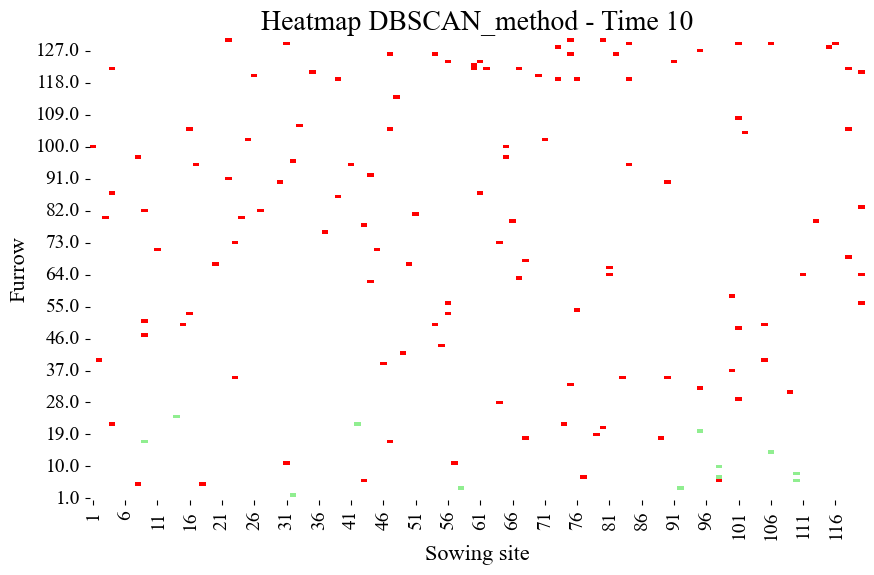

Método: Jenks_Natural_Breaks
Media: 0.891, Std: 0.312, Var: 0.098, CV: 10.94%, Prob. planta enferma: 1.000


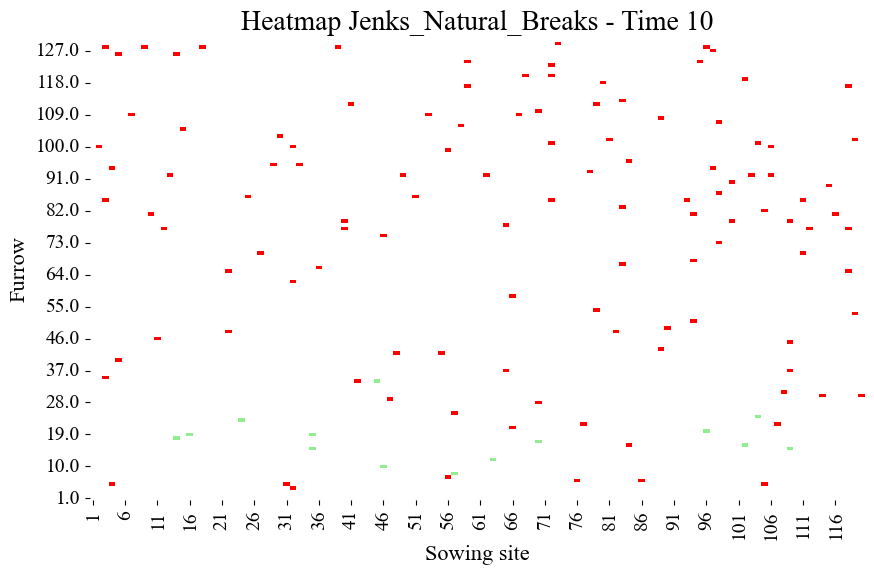


--- Tiempo: 11 | Tamaño muestra ajustado: 78 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.936, Std: 0.247, Var: 0.061, CV: 6.49%, Prob. planta enferma: 1.000


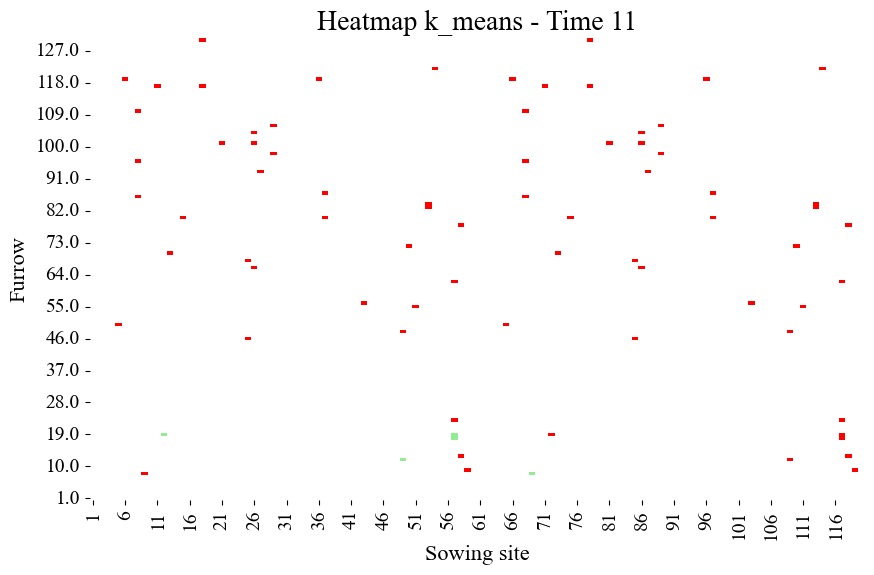

Método: DBSCAN_method
Media: 0.936, Std: 0.247, Var: 0.061, CV: 6.49%, Prob. planta enferma: 1.000


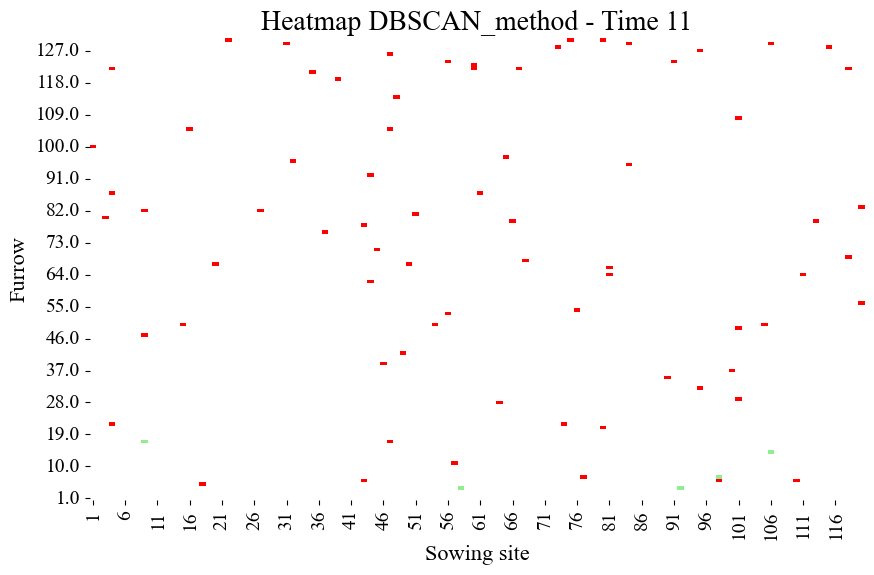

Método: Jenks_Natural_Breaks
Media: 0.921, Std: 0.271, Var: 0.074, CV: 8.00%, Prob. planta enferma: 1.000


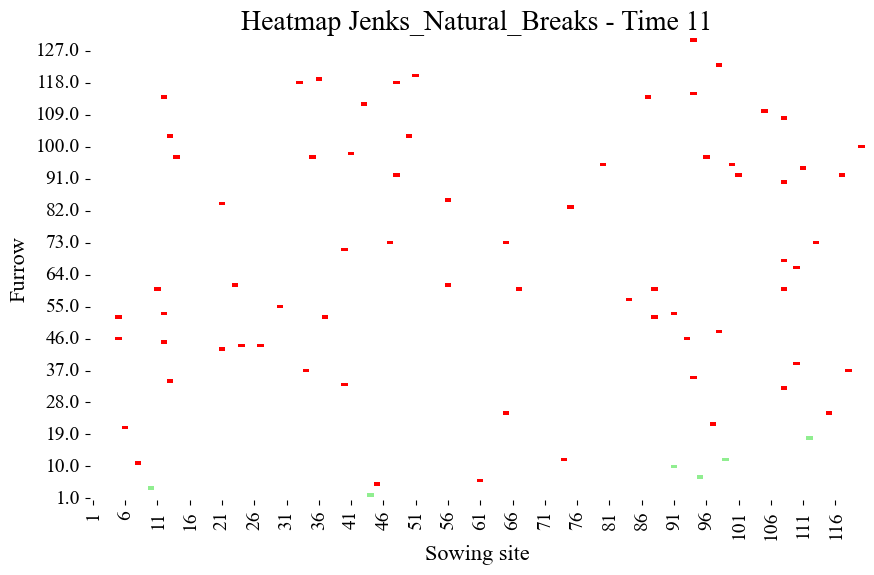


--- Tiempo: 12 | Tamaño muestra ajustado: 39 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.974, Std: 0.162, Var: 0.026, CV: 2.70%, Prob. planta enferma: 1.000


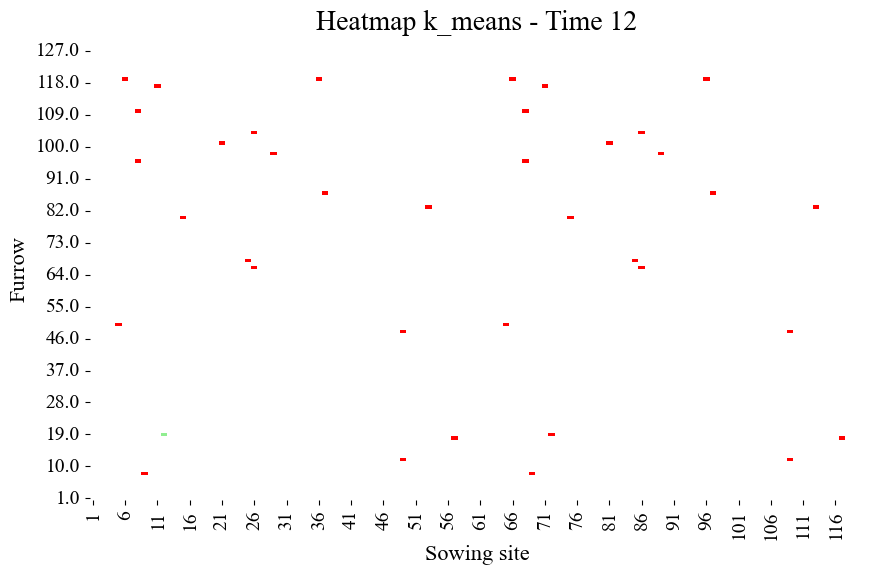

Método: DBSCAN_method
Media: 0.974, Std: 0.160, Var: 0.026, CV: 2.63%, Prob. planta enferma: 1.000


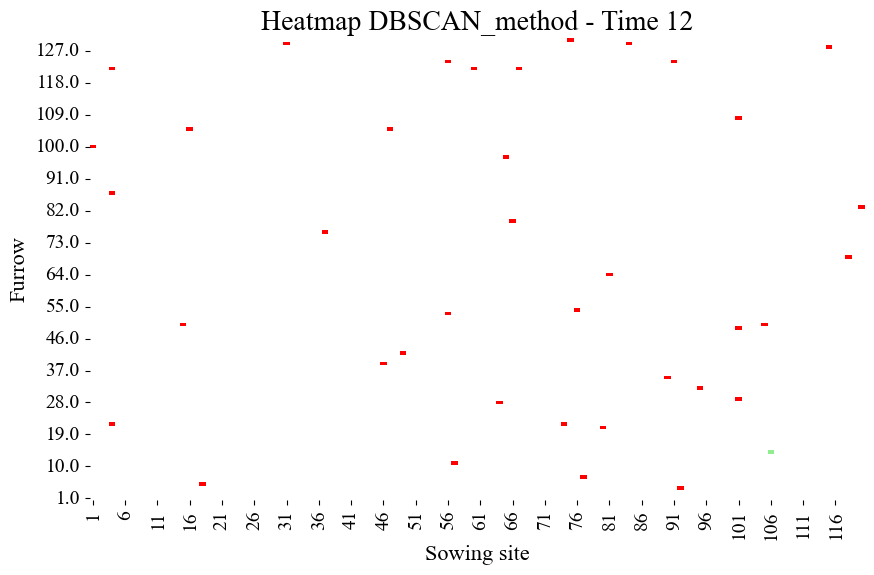

Método: Jenks_Natural_Breaks
Media: 0.973, Std: 0.164, Var: 0.027, CV: 2.78%, Prob. planta enferma: 1.000


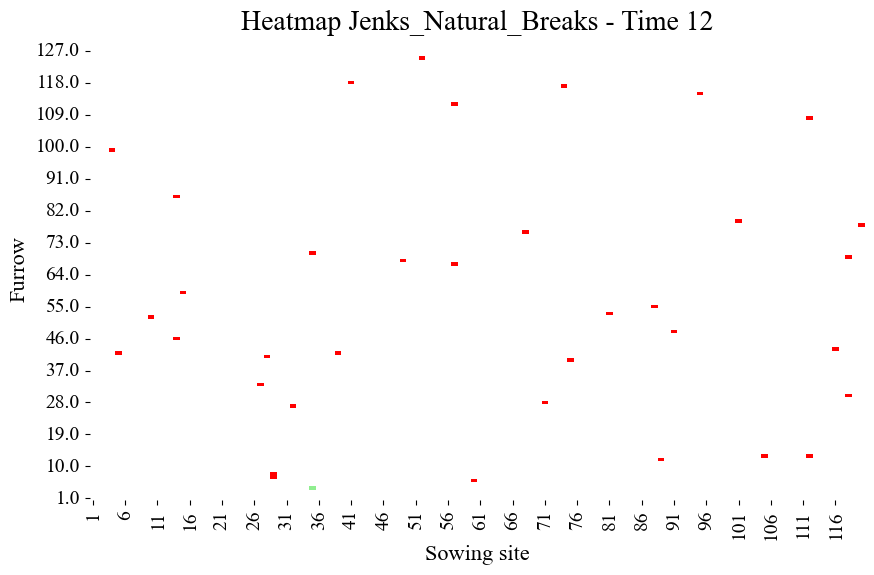

In [17]:
resultados = []

for tiempo in n_opt['Tiempo'].unique():
    df_tiempo = data_35[data_35['Tiempo'] == tiempo].copy()
    n_val = n_opt.loc[n_opt['Tiempo'] == tiempo, 'n'].values
    if len(n_val) == 0:
        print(f"No hay valor de n para tiempo {tiempo}, se omite.")
        continue
    n_muestra = int(np.floor(n_val[0]))
    n_muestra = max(1, min(n_muestra, len(df_tiempo)))

    print(f"\n--- Tiempo: {tiempo} | Tamaño muestra ajustado: {n_muestra} ---")

    for metodo, funcion_muestreo in metodos.items():
        try:
            sample = funcion_muestreo(df_tiempo, n_muestra)
        except ValueError as e:
            print(f"Error muestreando método {metodo} en tiempo {tiempo}: {e}")
            continue

        media, std, var, cv, prob_enferma = calcular_estadisticas(sample)

        print(f"Método: {metodo}")
        print(f"Media: {media:.3f}, Std: {std:.3f}, Var: {var:.3f}, CV: {cv:.2f}%, Prob. planta enferma: {prob_enferma:.3f}")

        plot_heatmap(sample, tiempo, metodo, df_tiempo)

        resultados.append({
            'Tiempo': tiempo,
            'Método': metodo,
            'Media': media,
            'Std': std,
            'Var': var,
            'CV (%)': cv,
            'Probabilidad planta enferma': prob_enferma
        })

df_resultados = pd.DataFrame(resultados)


--- Tiempo: 1 | Tamaño muestra ajustado: 15 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.000, Std: 0.000, Var: 0.000, CV: nan%, Prob. planta enferma: 0.000


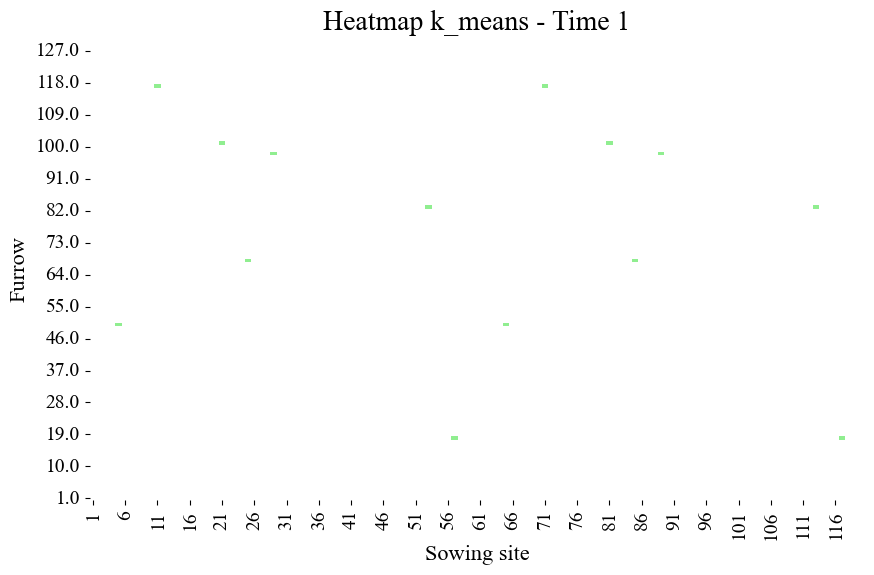

Método: DBSCAN_method
Media: 0.000, Std: 0.000, Var: 0.000, CV: nan%, Prob. planta enferma: 0.000


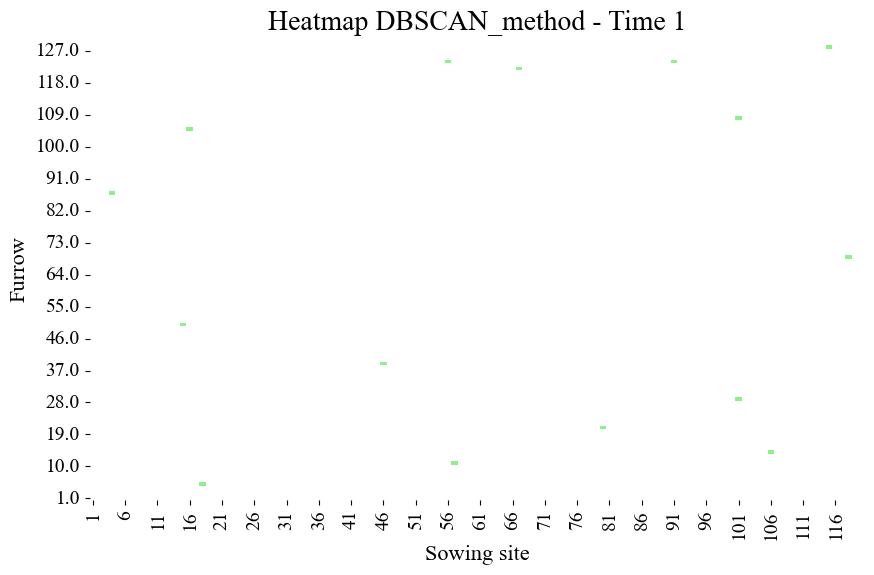

Método: Jenks_Natural_Breaks
Media: 0.077, Std: 0.277, Var: 0.077, CV: 100.00%, Prob. planta enferma: 0.647


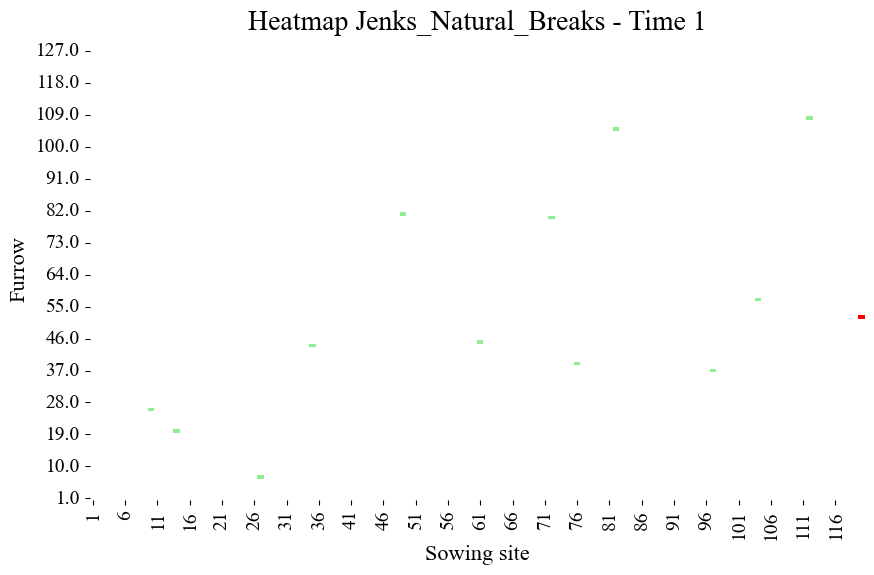


--- Tiempo: 2 | Tamaño muestra ajustado: 25 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.000, Std: 0.000, Var: 0.000, CV: nan%, Prob. planta enferma: 0.000


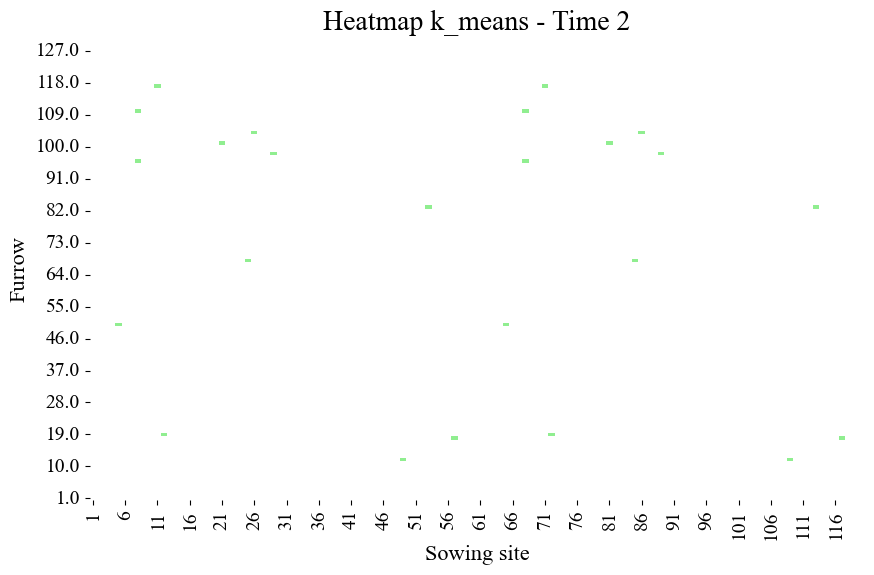

Método: DBSCAN_method
Media: 0.040, Std: 0.200, Var: 0.040, CV: 100.00%, Prob. planta enferma: 0.640


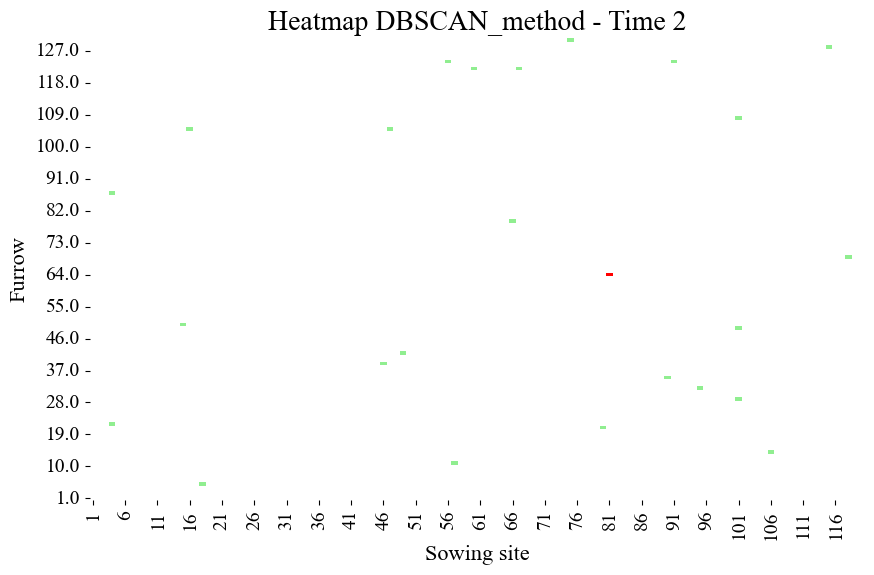

Método: Jenks_Natural_Breaks
Media: 0.042, Std: 0.204, Var: 0.042, CV: 100.00%, Prob. planta enferma: 0.640


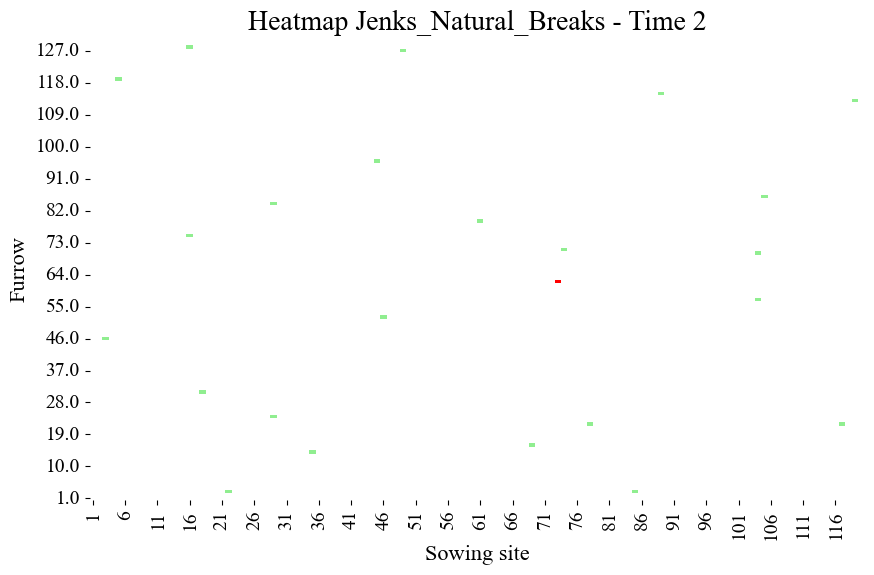


--- Tiempo: 3 | Tamaño muestra ajustado: 30 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.133, Std: 0.346, Var: 0.120, CV: 89.66%, Prob. planta enferma: 0.986


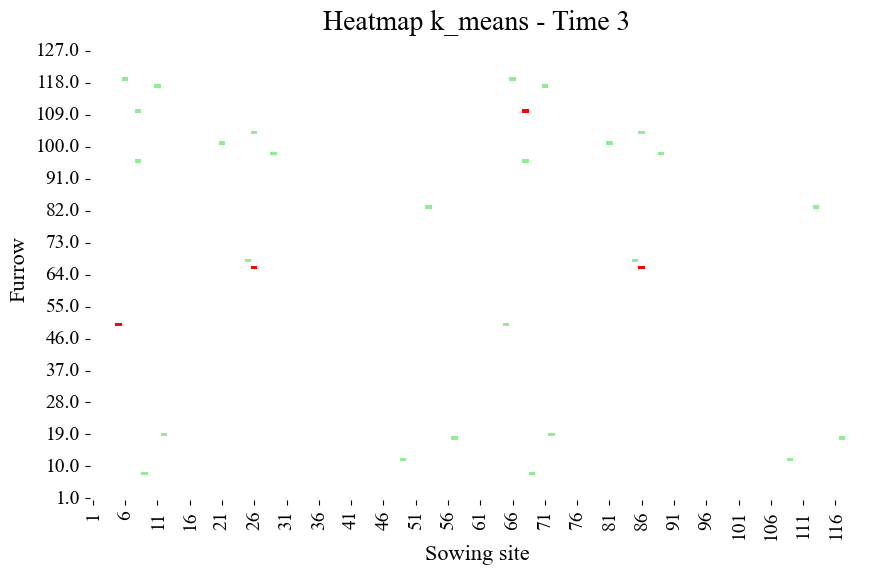

Método: DBSCAN_method
Media: 0.133, Std: 0.346, Var: 0.120, CV: 89.66%, Prob. planta enferma: 0.986


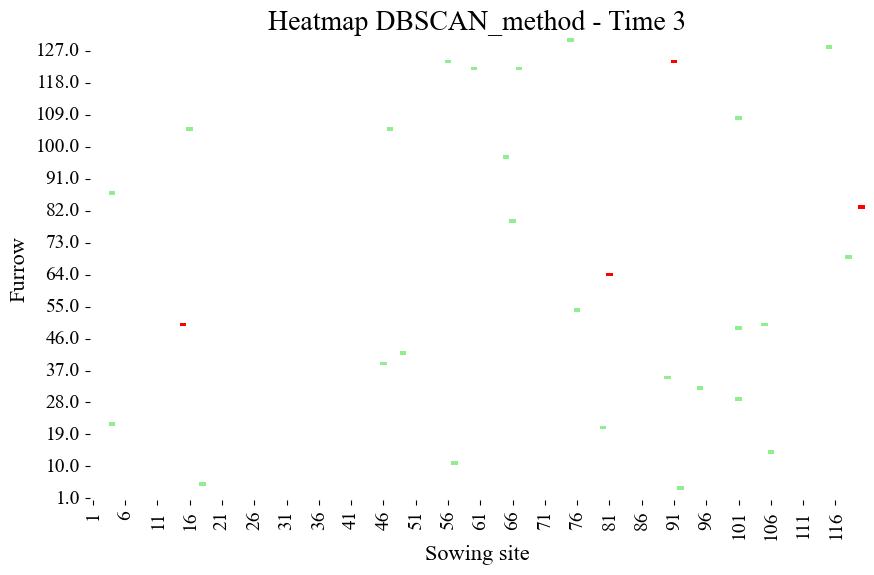

Método: Jenks_Natural_Breaks
Media: 0.138, Std: 0.351, Var: 0.123, CV: 89.29%, Prob. planta enferma: 0.986


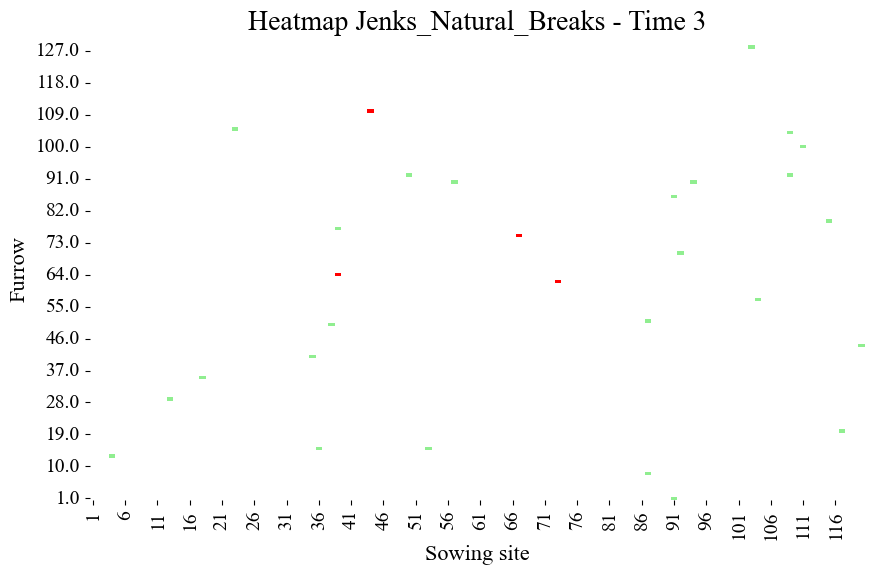


--- Tiempo: 4 | Tamaño muestra ajustado: 45 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.159, Std: 0.370, Var: 0.137, CV: 86.05%, Prob. planta enferma: 1.000


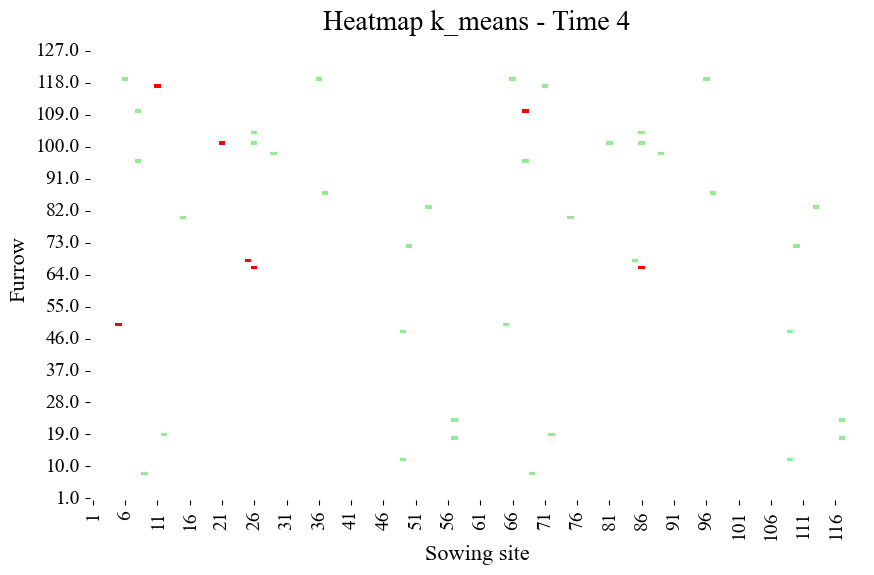

Método: DBSCAN_method
Media: 0.289, Std: 0.458, Var: 0.210, CV: 72.73%, Prob. planta enferma: 1.000


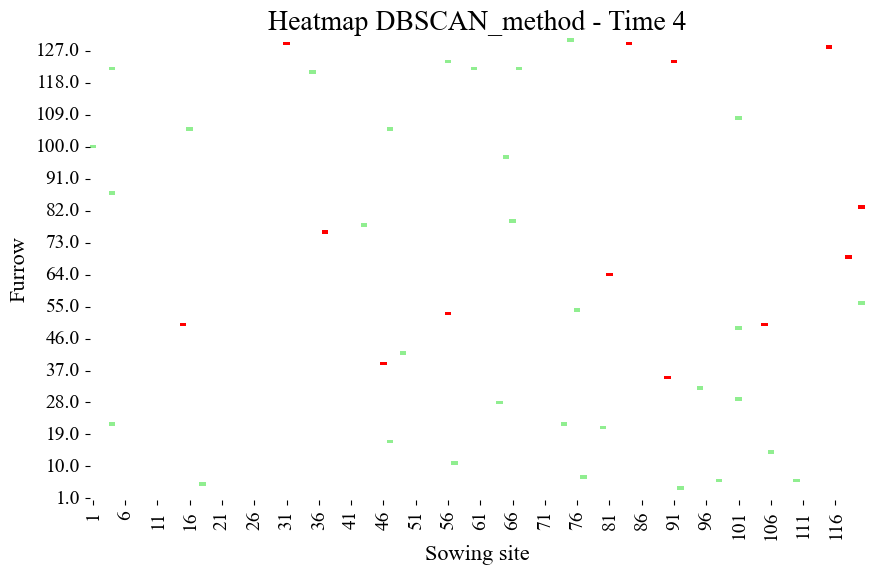

Método: Jenks_Natural_Breaks
Media: 0.163, Std: 0.374, Var: 0.140, CV: 85.71%, Prob. planta enferma: 1.000


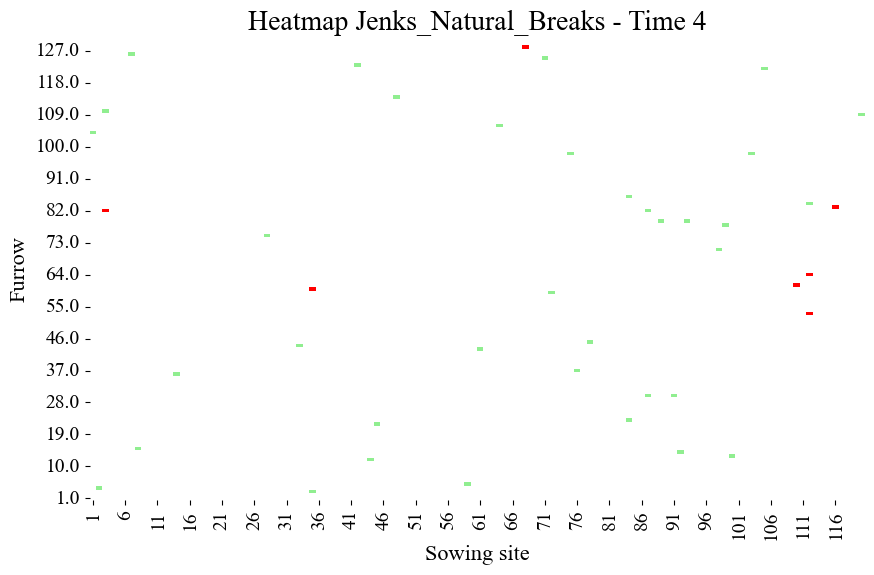


--- Tiempo: 5 | Tamaño muestra ajustado: 65 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.297, Std: 0.460, Var: 0.212, CV: 71.43%, Prob. planta enferma: 1.000


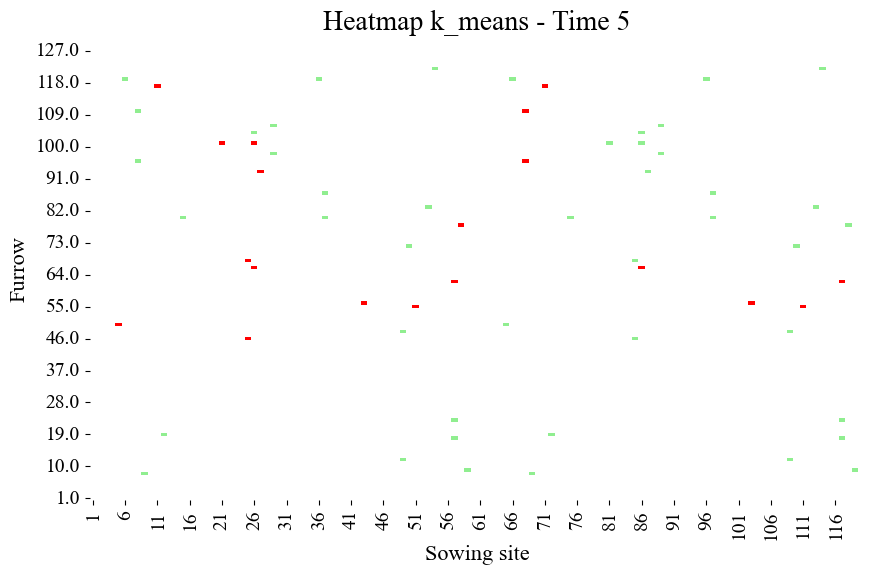

Método: DBSCAN_method
Media: 0.446, Std: 0.501, Var: 0.251, CV: 56.25%, Prob. planta enferma: 1.000


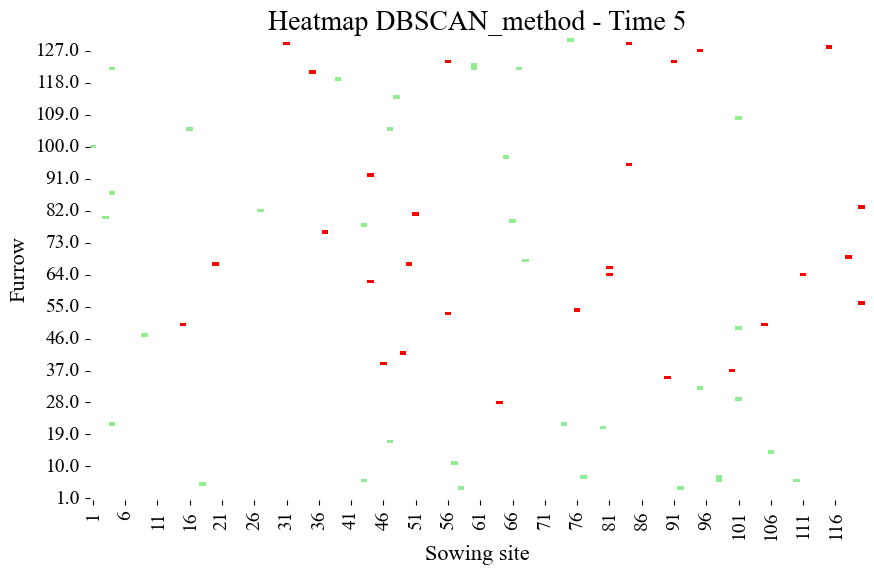

Método: Jenks_Natural_Breaks
Media: 0.413, Std: 0.496, Var: 0.246, CV: 59.68%, Prob. planta enferma: 1.000


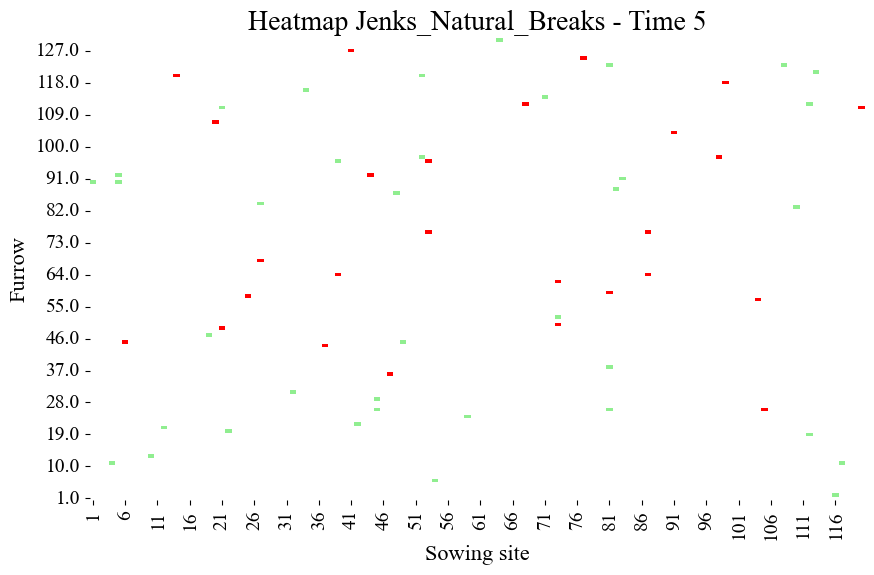


--- Tiempo: 6 | Tamaño muestra ajustado: 65 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.562, Std: 0.500, Var: 0.250, CV: 44.44%, Prob. planta enferma: 1.000


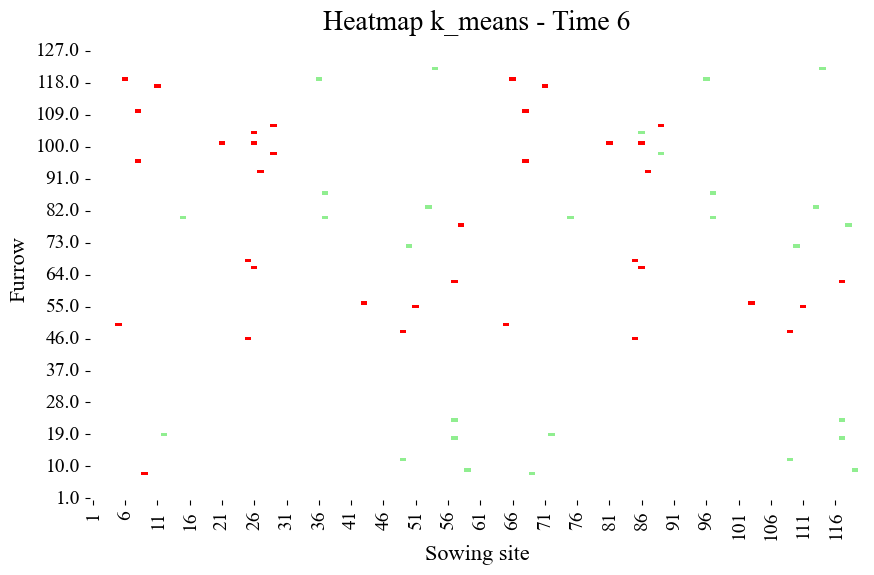

Método: DBSCAN_method
Media: 0.538, Std: 0.502, Var: 0.252, CV: 46.88%, Prob. planta enferma: 1.000


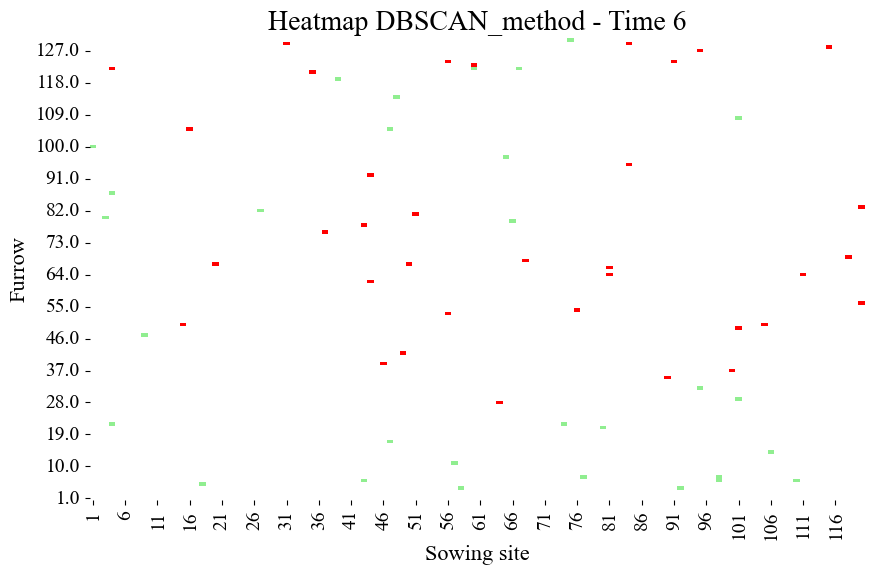

Método: Jenks_Natural_Breaks
Media: 0.460, Std: 0.502, Var: 0.252, CV: 54.84%, Prob. planta enferma: 1.000


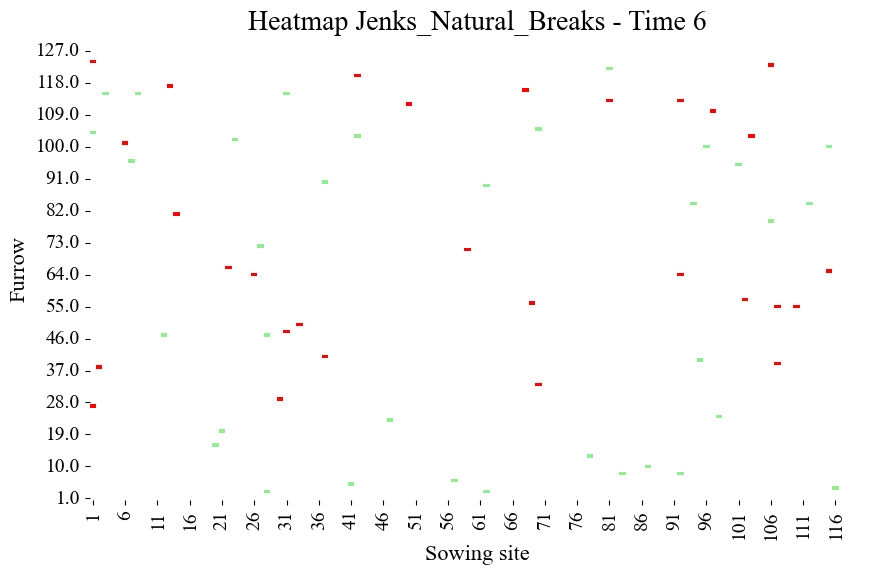


--- Tiempo: 7 | Tamaño muestra ajustado: 60 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.700, Std: 0.462, Var: 0.214, CV: 30.51%, Prob. planta enferma: 1.000


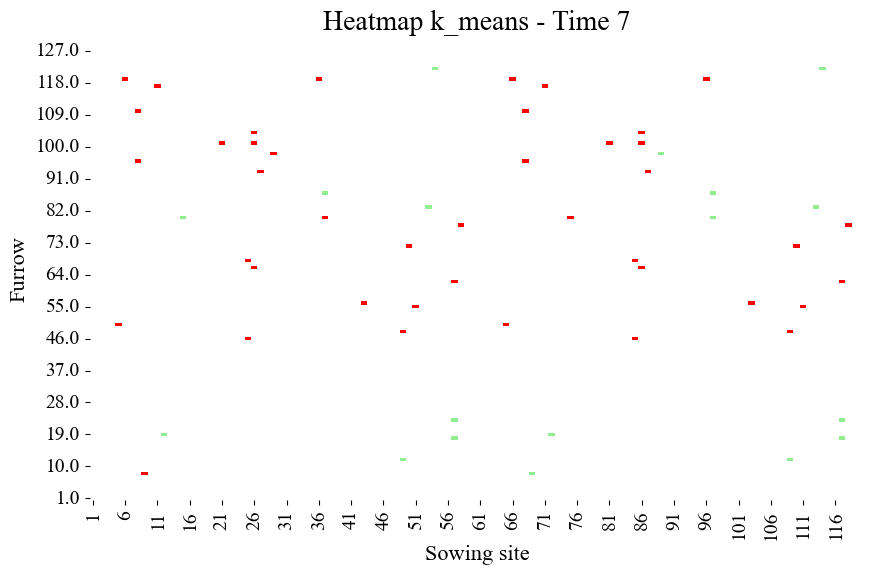

Método: DBSCAN_method
Media: 0.700, Std: 0.462, Var: 0.214, CV: 30.51%, Prob. planta enferma: 1.000


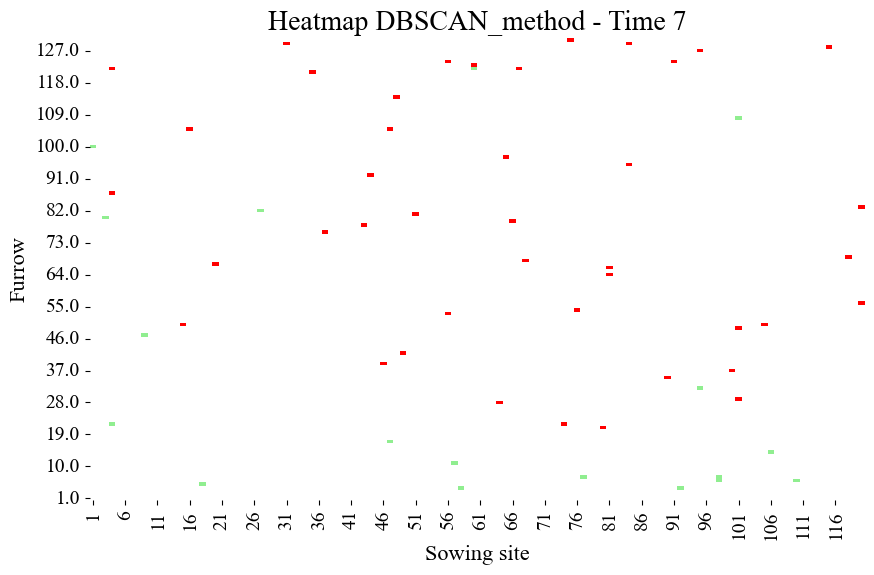

Método: Jenks_Natural_Breaks
Media: 0.661, Std: 0.477, Var: 0.228, CV: 34.48%, Prob. planta enferma: 1.000


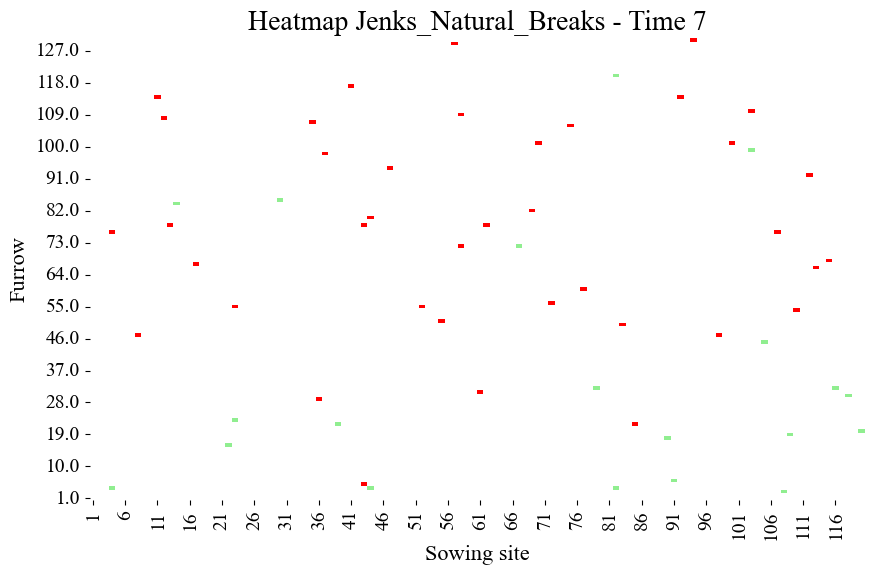


--- Tiempo: 8 | Tamaño muestra ajustado: 50 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.740, Std: 0.443, Var: 0.196, CV: 26.53%, Prob. planta enferma: 1.000


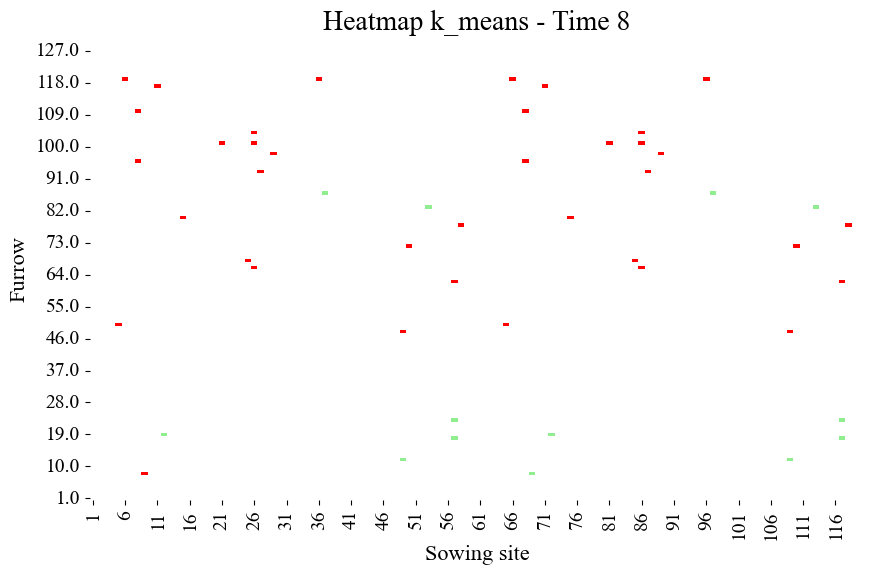

Método: DBSCAN_method
Media: 0.780, Std: 0.418, Var: 0.175, CV: 22.45%, Prob. planta enferma: 1.000


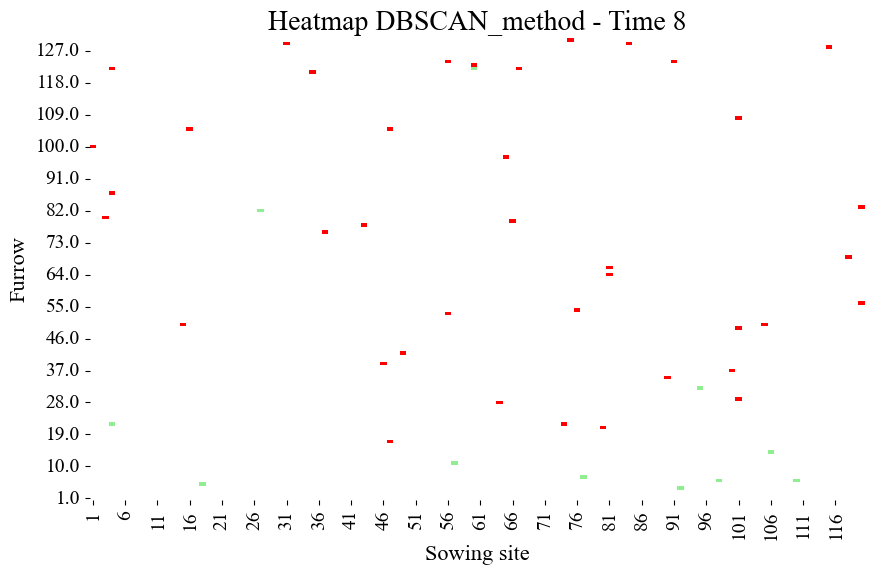

Método: Jenks_Natural_Breaks
Media: 0.755, Std: 0.434, Var: 0.189, CV: 25.00%, Prob. planta enferma: 1.000


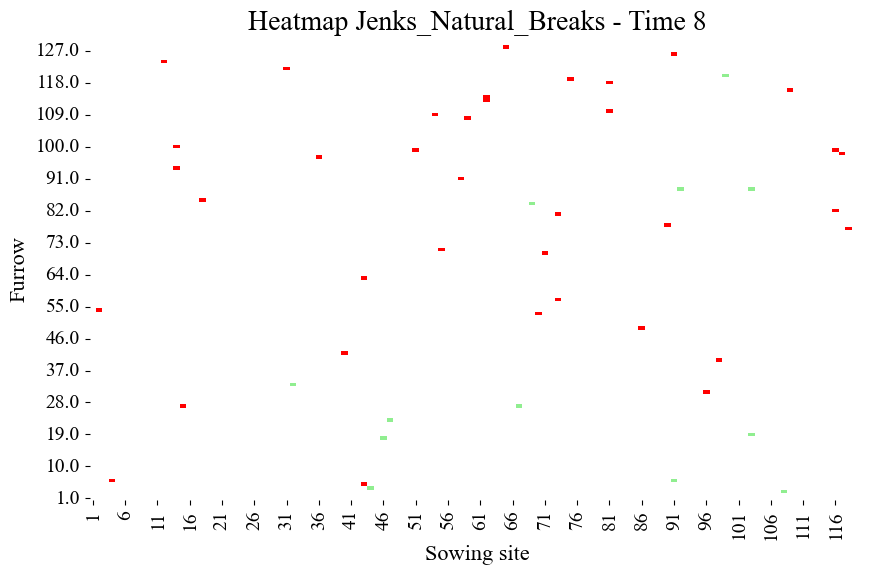


--- Tiempo: 9 | Tamaño muestra ajustado: 35 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.765, Std: 0.431, Var: 0.185, CV: 24.24%, Prob. planta enferma: 1.000


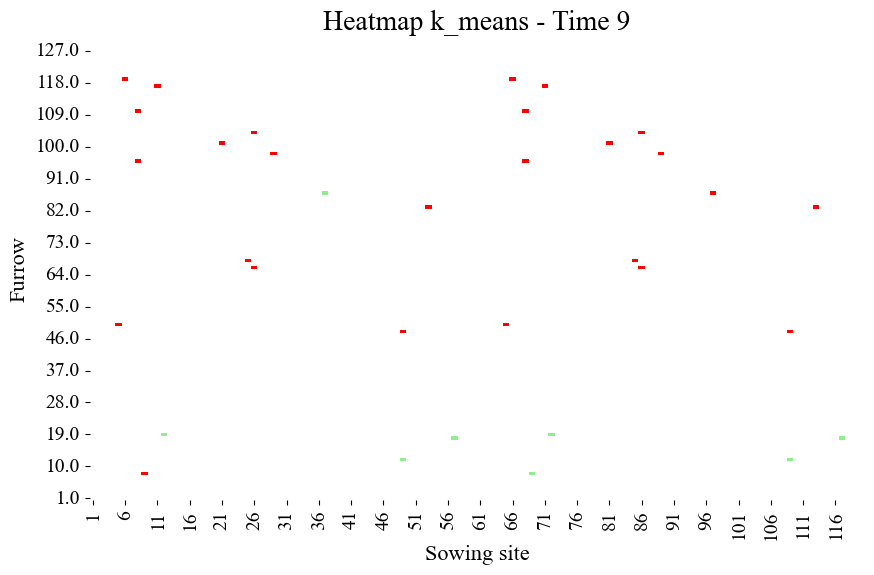

Método: DBSCAN_method
Media: 0.829, Std: 0.382, Var: 0.146, CV: 17.65%, Prob. planta enferma: 1.000


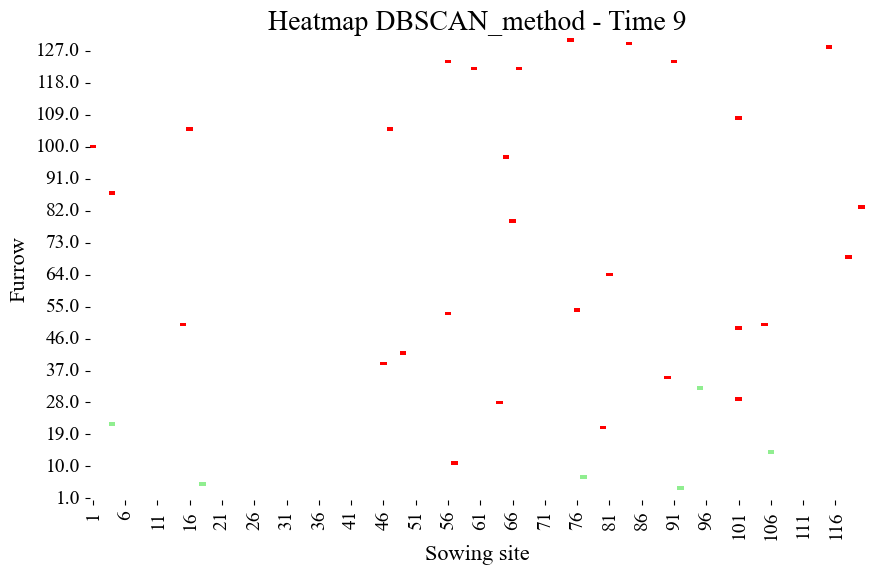

Método: Jenks_Natural_Breaks
Media: 0.848, Std: 0.364, Var: 0.133, CV: 15.63%, Prob. planta enferma: 1.000


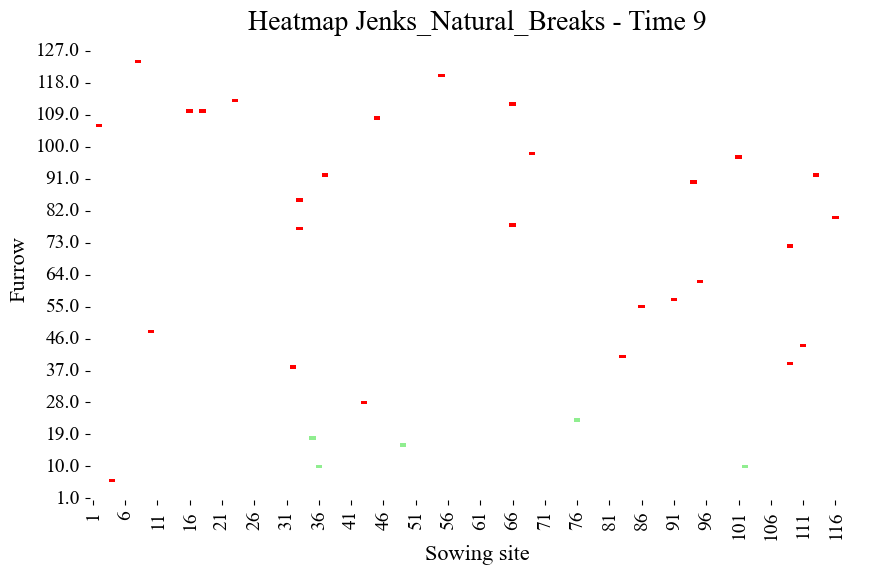


--- Tiempo: 10 | Tamaño muestra ajustado: 25 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.875, Std: 0.338, Var: 0.114, CV: 13.04%, Prob. planta enferma: 1.000


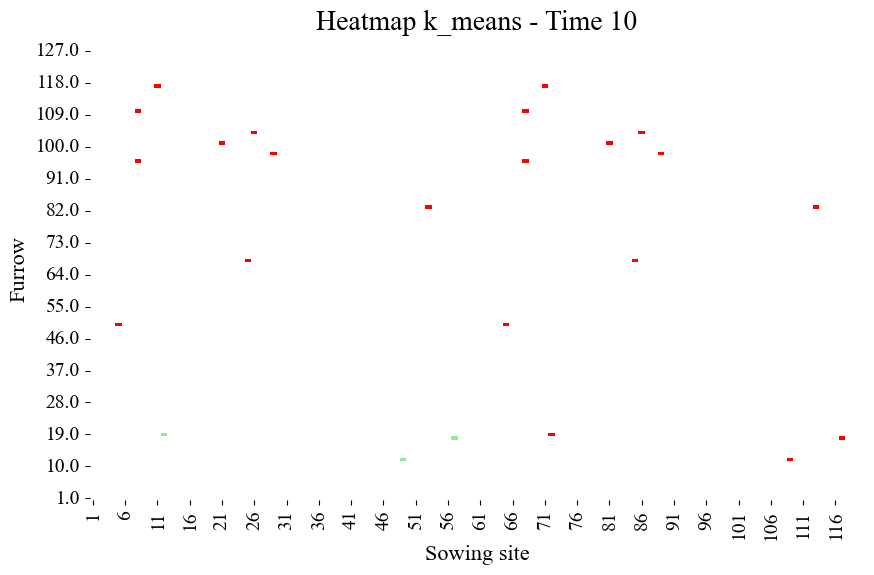

Método: DBSCAN_method
Media: 0.960, Std: 0.200, Var: 0.040, CV: 4.17%, Prob. planta enferma: 1.000


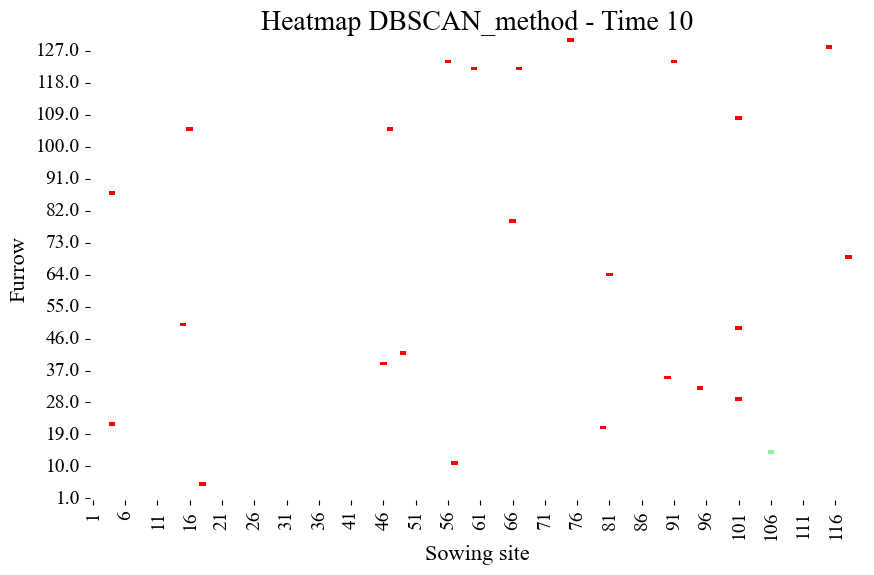

Método: Jenks_Natural_Breaks
Media: 0.917, Std: 0.282, Var: 0.080, CV: 8.70%, Prob. planta enferma: 1.000


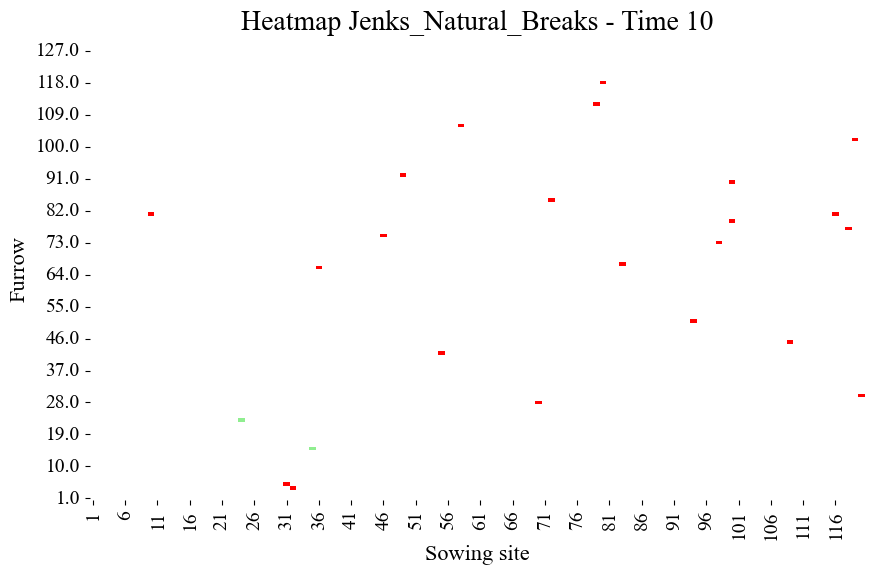


--- Tiempo: 11 | Tamaño muestra ajustado: 15 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 0.929, Std: 0.267, Var: 0.071, CV: 7.69%, Prob. planta enferma: 1.000


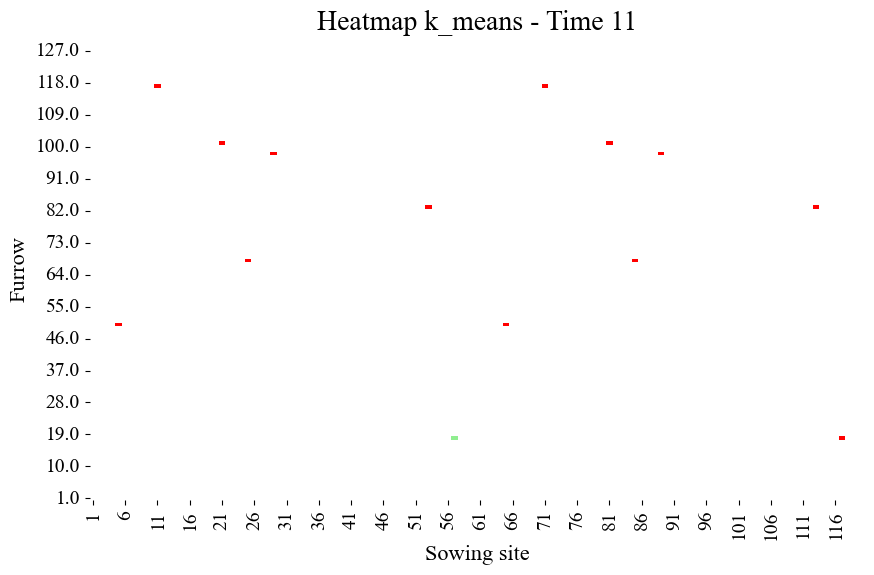

Método: DBSCAN_method
Media: 0.933, Std: 0.258, Var: 0.067, CV: 7.14%, Prob. planta enferma: 1.000


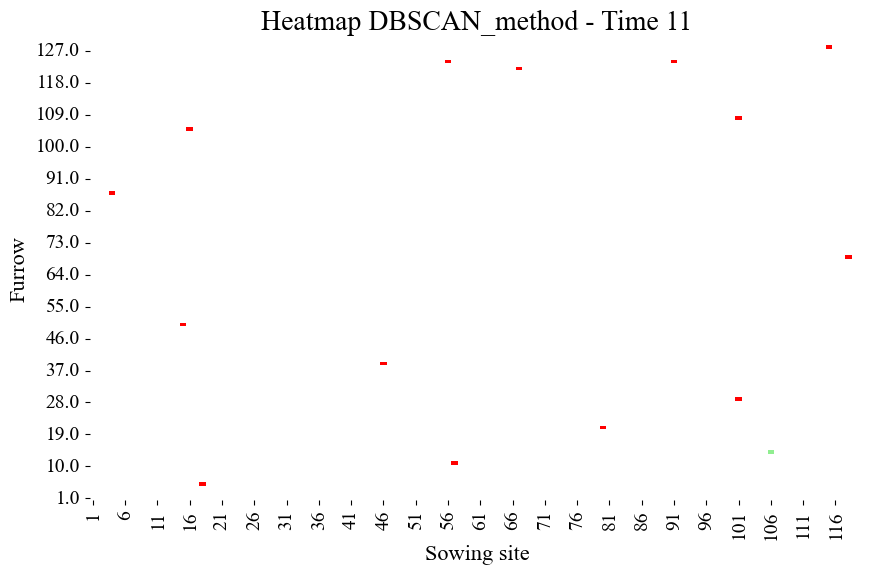

Método: Jenks_Natural_Breaks
Media: 0.923, Std: 0.277, Var: 0.077, CV: 8.33%, Prob. planta enferma: 1.000


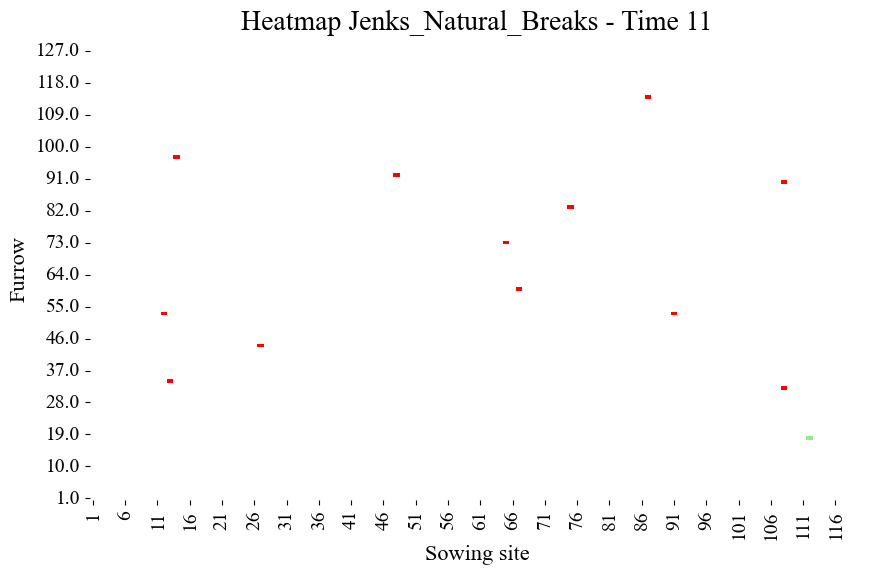


--- Tiempo: 12 | Tamaño muestra ajustado: 10 ---
Selected number of clusters by elbow method: 2
Método: k_means
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


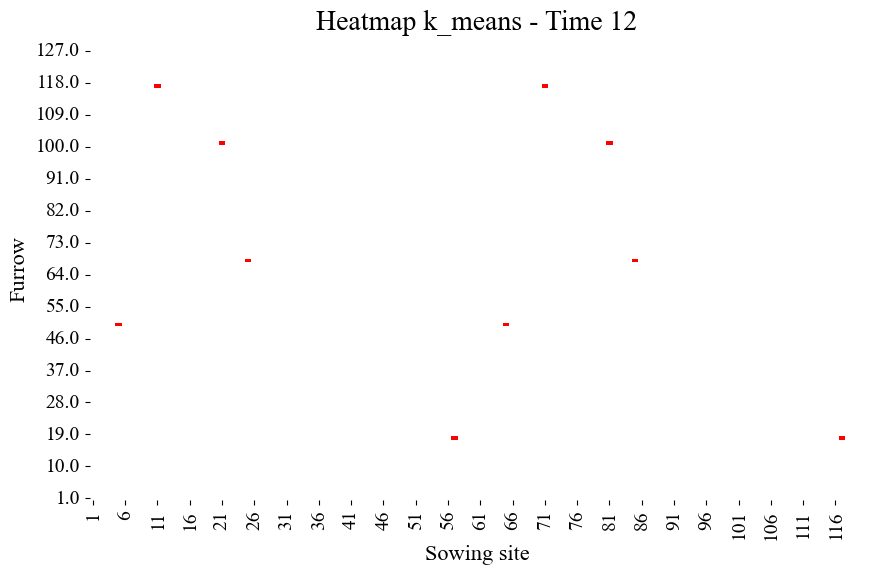

Método: DBSCAN_method
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


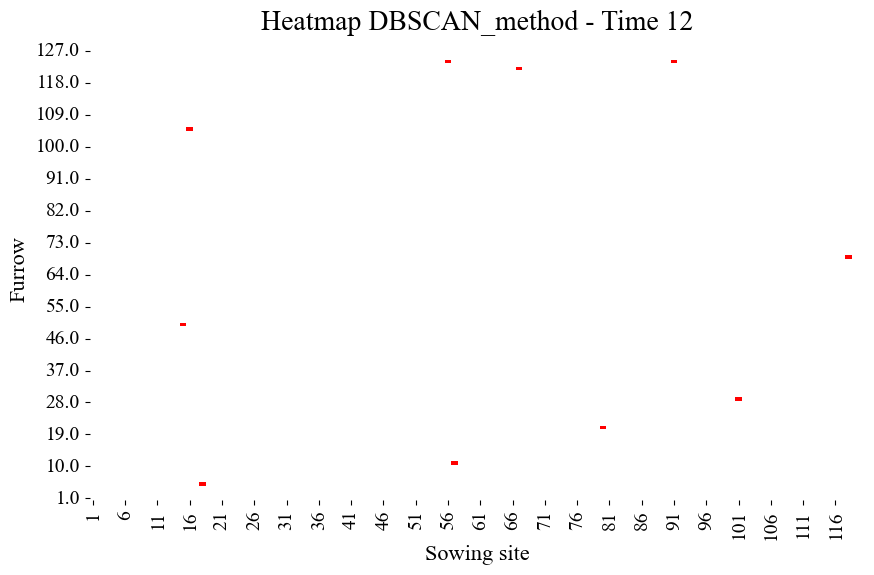

Método: Jenks_Natural_Breaks
Media: 1.000, Std: 0.000, Var: 0.000, CV: 0.00%, Prob. planta enferma: 1.000


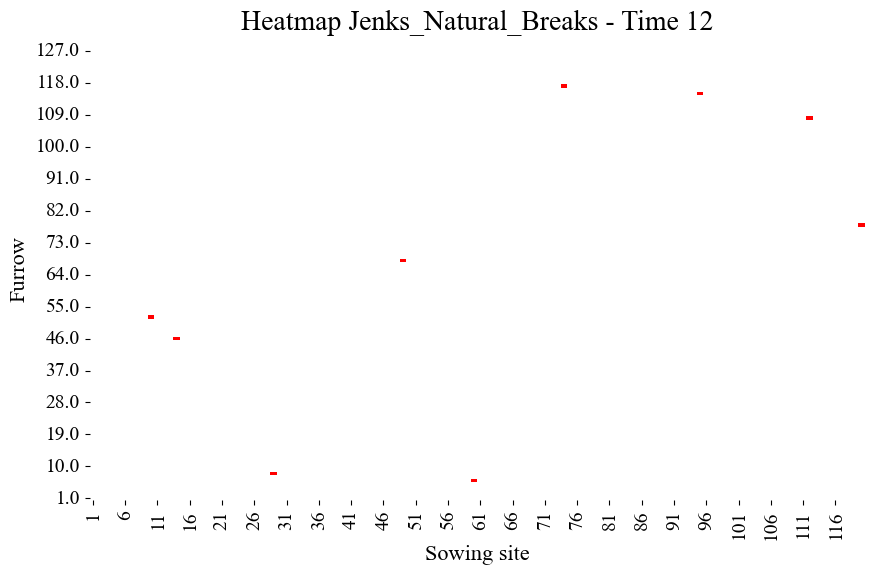

In [18]:
resultados = []

for tiempo in n_opt['Tiempo'].unique():
    df_tiempo = data_35[data_35['Tiempo'] == tiempo].copy()
    n_val = n_opt.loc[n_opt['Tiempo'] == tiempo, 'n_MC'].values
    if len(n_val) == 0:
        print(f"No hay valor de n para tiempo {tiempo}, se omite.")
        continue
    n_muestra = int(np.floor(n_val[0]))
    n_muestra = max(1, min(n_muestra, len(df_tiempo)))

    print(f"\n--- Tiempo: {tiempo} | Tamaño muestra ajustado: {n_muestra} ---")

    for metodo, funcion_muestreo in metodos.items():
        try:
            sample = funcion_muestreo(df_tiempo, n_muestra)
        except ValueError as e:
            print(f"Error muestreando método {metodo} en tiempo {tiempo}: {e}")
            continue

        media, std, var, cv, prob_enferma = calcular_estadisticas(sample)

        print(f"Método: {metodo}")
        print(f"Media: {media:.3f}, Std: {std:.3f}, Var: {var:.3f}, CV: {cv:.2f}%, Prob. planta enferma: {prob_enferma:.3f}")

        plot_heatmap(sample, tiempo, metodo, df_tiempo)

        resultados.append({
            'Tiempo': tiempo,
            'Método': metodo,
            'Media': media,
            'Std': std,
            'Var': var,
            'CV (%)': cv,
            'Probabilidad planta enferma': prob_enferma
        })

df_resultadosMC = pd.DataFrame(resultados)

In [19]:
población.columns = ['Nave', 'Tiempo', 'media_población', 'std_población', 'var_población', 'coef_var_población']
final = pd.merge(df_resultados,población[población['Nave']==35],on='Tiempo')

In [20]:
df_resultadosMC.columns = ['Tiempo', 'Método', 'MediaMC', 'StdMC', 'VarMC', 'CV (%)MC','Probabilidad planta enfermaMC']

In [21]:
final = pd.merge(df_resultadosMC,final,on=['Tiempo','Método'])

In [22]:
final['Bias T'] = final.apply(lambda x: (x['Media']-x['media_población'])/x['media_población']*100,axis=1)
final['Precision_relativa T'] = final['CV (%)'] / final['coef_var_población']

final['Bias MC'] = final.apply(lambda x: (x['MediaMC']-x['media_población'])/x['media_población']*100,axis=1)
final['Precision_relativa MC'] = final['CV (%)MC'] / final['coef_var_población']
final = round(final,2)

In [23]:
final = final[['Método','Bias T','Precision_relativa T', 'Bias MC','Precision_relativa MC']]
final = final.melt(id_vars='Método')
final.columns = ['Method','Metric','Value']

In [24]:
final['Method'] = final['Method'].replace({'k_means':'K means', 
                                           'DBSCAN_method':'DBSCAN', 
                                           'Jenks_Natural_Breaks':'Jenks Natural Breaks'},regex=True)
final['Metric'] = final['Metric'].replace({'Precision_relativa':'Relative precision'},regex=True)

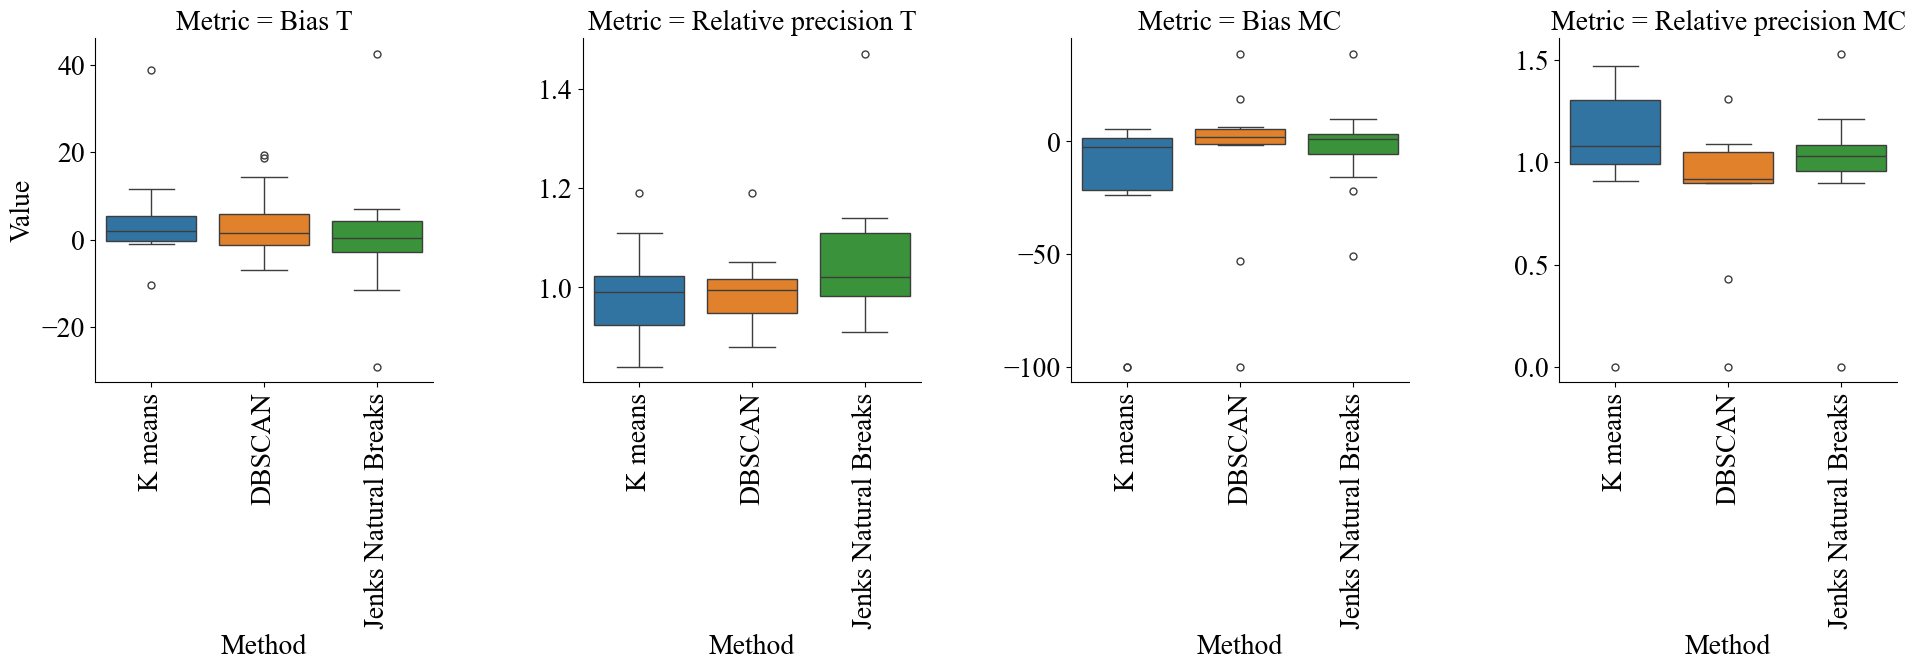

In [25]:
g = sns.catplot(data=final, x='Method', y='Value', col='Metric',  kind='box', hue='Method', sharey=False)
g.set_xticklabels(rotation=90)

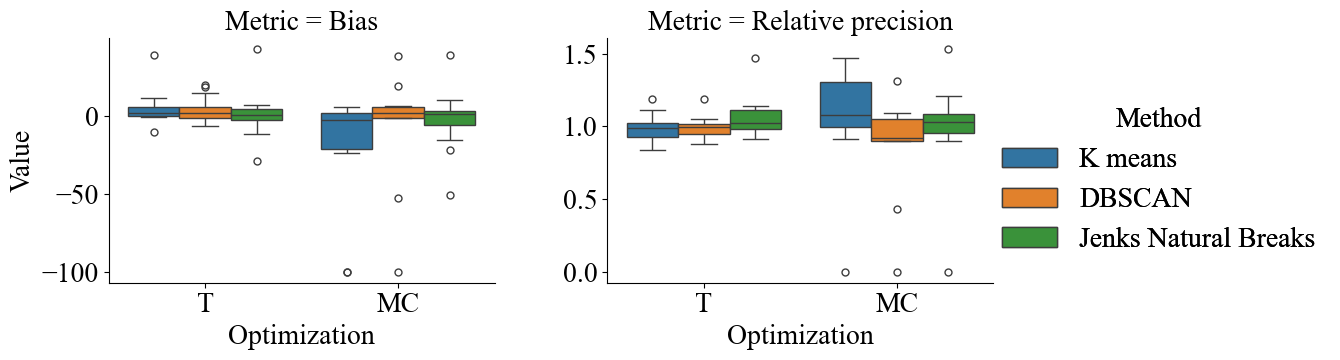

In [26]:
final[['Metric','Optimization']] = final['Metric'].str.rsplit(' ', n=1, expand=True)
final['Metric']  = final['Metric'].str.strip()
final['Optimization'] = final['Optimization'].str.strip()

final = final[final['Optimization'].isin(['T','MC'])].copy()
final['Optimization'] = pd.Categorical(final['Optimization'], categories=['T','MC'], ordered=True)

order_metric = ['Bias', 'Relative precision']
final['Metric'] = pd.Categorical(final['Metric'], categories=order_metric, ordered=True)

g = sns.catplot(data=final, x='Optimization', y='Value', col='Metric', hue='Method', kind='box', order=['T','MC'], sharey=False, height=4, aspect=1)

g.set_axis_labels("Optimization", "Value")
g.add_legend(title='Method')
plt.show()
